In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
	accuracy_score,
	precision_score,
	recall_score,
	f1_score,
	confusion_matrix,
	roc_curve,
	auc,
	classification_report
)
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
def carregar_dados_csv(file):

	try:
		
		df_completo = pd.read_csv(file)

		return df_completo

	except FileNotFoundError:

		print(f"Erro: O arquivo '{file}' não foi encontrado.")
		print("Rode o ZeaMays para gerar o arquivo CSV.")
		return None

	except KeyError as e:

		print(f"Erro: Uma ou mais colunas não encontradas no arquivo: {e}")
		return None

	except Exception as e:

		print(f"Ocorreu um erro inesperado: {e}")
		return None

In [3]:
# metricas = "ZMays/Agrup/k-mer/k-mer_agrupado.csv"
metricas = "df_metricas_seq_final.csv"
# metricas = "/kaggle/input/df-metricas-seq-final-zeamays/df_metricas_seq_final.csv"

df_metricas = carregar_dados_csv(metricas)

if df_metricas is not None:
	print("\nHead do DataFrame:")
	print(df_metricas.shape)
	print(df_metricas.head())

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_11660\4259128047.py:5: DtypeWarning: Columns (48,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df_completo = pd.read_csv(file)



Head do DataFrame:
(107571, 5779)
   Chr SourceAnnotation                                    COS      Start  \
0    5           APTEdb  Class II subclass 2/Helitron/Helitron   28903351   
1    3           APTEdb  Class II subclass 2/Helitron/Helitron    2184634   
2    7           APTEdb  Class II subclass 2/Helitron/Helitron   82856122   
3    1           APTEdb  Class II subclass 2/Helitron/Helitron  185134318   
4    8           APTEdb  Class II subclass 2/Helitron/Helitron    2261318   

         End Score Strand Phase  \
0   28903636     .      -     .   
1    2185235     .      -     .   
2   82857584     .      +     .   
3  185151509     .      -     .   
4    2261604     .      +     .   

                                          Attributes  \
0  TE-Score=0.285;Software=RepeatModeler;Length=2...   
1  TE-Score=0.428;Software=RepeatMasker;Length=60...   
2  TE-Score=0.428;Software=RepeatModeler;Length=1...   
3  TE-Score=0.714;Software=HelitronScanner;Length...   
4  TE-Score

In [4]:
remover_colunas = ["Chr", "SourceAnnotation", "Start", "End", "Score", "Strand", "Phase", "Attributes", "label"]

df_metricas = df_metricas.drop(columns=remover_colunas)

print("\nDataFrame após remover colunas:")
print(df_metricas.shape)
print(df_metricas.head())


DataFrame após remover colunas:
(107571, 5770)
                                     COS  ZMays/Agrup\anf_fourier_average  \
0  Class II subclass 2/Helitron/Helitron                        22.959990   
1  Class II subclass 2/Helitron/Helitron                        44.649242   
2  Class II subclass 2/Helitron/Helitron                       113.012818   
3  Class II subclass 2/Helitron/Helitron                      1109.133954   
4  Class II subclass 2/Helitron/Helitron                        25.080989   

   ZMays/Agrup\anf_fourier_median  ZMays/Agrup\anf_fourier_maximum  \
0                        1.680885                     5.884405e+03   
1                        1.594868                     2.543616e+04   
2                        4.545350                     1.550335e+05   
3                       10.007322                     1.881748e+07   
4                        1.818602                     6.515580e+03   

   ZMays/Agrup\anf_fourier_minimum  ZMays/Agrup\anf_fourier_peak  \


In [5]:
coluna_alvo = 'COS'

In [6]:
def verfica_unique (df, coluna):
	
	if coluna in df.columns:

		contagem_valores = df[coluna].value_counts()

		print(f"Contagem de cada valor único na coluna '{coluna}':")
		print(contagem_valores)

		valores_unicos = df[coluna].unique()
		print(f"\nValores únicos na coluna '{coluna}':")
		print(valores_unicos)

		numero_de_valores_unicos = df[coluna].nunique()
		print(f"\nA coluna '{coluna}' possui {numero_de_valores_unicos} valores únicos distintos.")

	else:
		print(f"A coluna '{coluna}' não foi encontrada no DataFrame.")
		print("Colunas disponíveis:", df.columns.tolist())

verfica_unique(df_metricas, coluna_alvo)

Contagem de cada valor único na coluna 'COS':
COS
Class I/LTR/Gypsy                         20992
Class II subclass 2/Helitron/Helitron     16337
Class II subclass 2/MITE/MITE             15126
Class I/LINE/L1                           11217
Class I/LTR/Copia                         11181
Class I/SINE/tRNA                          3677
Class II subclass 1/TIR/PIF-Harbinger      3460
Class I/LTR/LARD                           3232
Class I/LTR/Unknown                        2940
Class II subclass 1/TIR/hAT                2712
Class II subclass 1/TIR/Harbinger          2244
Class II subclass 1/TIR/Unknown            1925
Class II subclass 1/TIR/CMC-EnSpm          1573
Class I/LINE/Unknown                       1531
Class II subclass 1/TIR/EnSpm-CACTA        1477
Class II subclass 1/TIR/MuDR               1435
Class II subclass 1/TIR/hAT-Ac             1434
Class I/SINE/Unknown                       1333
Class II subclass 1/TIR/MuLE-MuDR           954
Class II subclass 1/TIR/TcMar-Stowaway

In [7]:
def extrair_elemento_transponivel(texto):
  
	try:
		return texto.split('/')[1]
	except IndexError:
		return
	
df_metricas[coluna_alvo] = df_metricas[coluna_alvo].apply(extrair_elemento_transponivel)

verfica_unique(df_metricas, coluna_alvo)

Contagem de cada valor único na coluna 'COS':
COS
LTR         38795
TIR         18995
Helitron    16337
MITE        15126
LINE        13046
SINE         5272
Name: count, dtype: int64

Valores únicos na coluna 'COS':
['Helitron' 'LINE' 'LTR' 'MITE' 'SINE' 'TIR']

A coluna 'COS' possui 6 valores únicos distintos.


In [8]:
ocorrencia = 1

contagens = df_metricas[coluna_alvo].value_counts()

valores_para_manter = contagens[contagens > ocorrencia].index

df_metricas = df_metricas[df_metricas[coluna_alvo].isin(valores_para_manter)]

verfica_unique(df_metricas, coluna_alvo)

Contagem de cada valor único na coluna 'COS':
COS
LTR         38795
TIR         18995
Helitron    16337
MITE        15126
LINE        13046
SINE         5272
Name: count, dtype: int64

Valores únicos na coluna 'COS':
['Helitron' 'LINE' 'LTR' 'MITE' 'SINE' 'TIR']

A coluna 'COS' possui 6 valores únicos distintos.


In [9]:
df_metricas.shape

(107571, 5770)

In [10]:
# Defina todos os prefixos que você quer remover em uma tupla
prefixos_para_remover = (r'ZMays/Agrup\chaos_', r'ZMays/Agrup\anf_fourier_class')
sufixo_para_remover = '_class'

colunas_para_remover = [
    col for col in df_metricas.columns
    if col.startswith(prefixos_para_remover) or col.endswith(sufixo_para_remover)
]

df_metricas = df_metricas.drop(columns=colunas_para_remover)

print("Total de colunas removidas:", len(colunas_para_remover))
print("Nomes das colunas removidas:", colunas_para_remover) # Opcional, pode ser uma lista grande
print("\nFormato do DataFrame Original:", df_metricas.shape)
print("Novo formato do DataFrame Limpo:", df_metricas.shape)
print("\nPrimeiras linhas do DataFrame limpo:")
print(df_metricas.head())

Total de colunas removidas: 51
Nomes das colunas removidas: ['ZMays/Agrup\\anf_fourier_class', 'ZMays/Agrup\\chaos_signal_classic_average', 'ZMays/Agrup\\chaos_signal_classic_median', 'ZMays/Agrup\\chaos_signal_classic_maximum', 'ZMays/Agrup\\chaos_signal_classic_minimum', 'ZMays/Agrup\\chaos_signal_classic_peak', 'ZMays/Agrup\\chaos_signal_classic_none_levated_peak', 'ZMays/Agrup\\chaos_signal_classic_sample_standard_deviation', 'ZMays/Agrup\\chaos_signal_classic_population_standard_deviation', 'ZMays/Agrup\\chaos_signal_classic_percentile15', 'ZMays/Agrup\\chaos_signal_classic_percentile25', 'ZMays/Agrup\\chaos_signal_classic_percentile50', 'ZMays/Agrup\\chaos_signal_classic_percentile75', 'ZMays/Agrup\\chaos_signal_classic_amplitude', 'ZMays/Agrup\\chaos_signal_classic_variance', 'ZMays/Agrup\\chaos_signal_classic_interquartile_range', 'ZMays/Agrup\\chaos_signal_classic_semi_interquartile_range', 'ZMays/Agrup\\chaos_signal_classic_coefficient_of_variation', 'ZMays/Agrup\\chaos_signa

In [11]:
# Defina todos os prefixos que você quer remover em uma tupla
kmer = ['COS', 'A', 'C', 'G', 'T', 'AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT', 'AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT', 'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT', 'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT', 'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT', 'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT', 'AAAA', 'AAAC', 'AAAG', 'AAAT', 'AACA', 'AACC', 'AACG', 'AACT', 'AAGA', 'AAGC', 'AAGG', 'AAGT', 'AATA', 'AATC', 'AATG', 'AATT', 'ACAA', 'ACAC', 'ACAG', 'ACAT', 'ACCA', 'ACCC', 'ACCG', 'ACCT', 'ACGA', 'ACGC', 'ACGG', 'ACGT', 'ACTA', 'ACTC', 'ACTG', 'ACTT', 'AGAA', 'AGAC', 'AGAG', 'AGAT', 'AGCA', 'AGCC', 'AGCG', 'AGCT', 'AGGA', 'AGGC', 'AGGG', 'AGGT', 'AGTA', 'AGTC', 'AGTG', 'AGTT', 'ATAA', 'ATAC', 'ATAG', 'ATAT', 'ATCA', 'ATCC', 'ATCG', 'ATCT', 'ATGA', 'ATGC', 'ATGG', 'ATGT', 'ATTA', 'ATTC', 'ATTG', 'ATTT', 'CAAA', 'CAAC', 'CAAG', 'CAAT', 'CACA', 'CACC', 'CACG', 'CACT', 'CAGA', 'CAGC', 'CAGG', 'CAGT', 'CATA', 'CATC', 'CATG', 'CATT', 'CCAA', 'CCAC', 'CCAG', 'CCAT', 'CCCA', 'CCCC', 'CCCG', 'CCCT', 'CCGA', 'CCGC', 'CCGG', 'CCGT', 'CCTA', 'CCTC', 'CCTG', 'CCTT', 'CGAA', 'CGAC', 'CGAG', 'CGAT', 'CGCA', 'CGCC', 'CGCG', 'CGCT', 'CGGA', 'CGGC', 'CGGG', 'CGGT', 'CGTA', 'CGTC', 'CGTG', 'CGTT', 'CTAA', 'CTAC', 'CTAG', 'CTAT', 'CTCA', 'CTCC', 'CTCG', 'CTCT', 'CTGA', 'CTGC', 'CTGG', 'CTGT', 'CTTA', 'CTTC', 'CTTG', 'CTTT', 'GAAA', 'GAAC', 'GAAG', 'GAAT', 'GACA', 'GACC', 'GACG', 'GACT', 'GAGA', 'GAGC', 'GAGG', 'GAGT', 'GATA', 'GATC', 'GATG', 'GATT', 'GCAA', 'GCAC', 'GCAG', 'GCAT', 'GCCA', 'GCCC', 'GCCG', 'GCCT', 'GCGA', 'GCGC', 'GCGG', 'GCGT', 'GCTA', 'GCTC', 'GCTG', 'GCTT', 'GGAA', 'GGAC', 'GGAG', 'GGAT', 'GGCA', 'GGCC', 'GGCG', 'GGCT', 'GGGA', 'GGGC', 'GGGG', 'GGGT', 'GGTA', 'GGTC', 'GGTG', 'GGTT', 'GTAA', 'GTAC', 'GTAG', 'GTAT', 'GTCA', 'GTCC', 'GTCG', 'GTCT', 'GTGA', 'GTGC', 'GTGG', 'GTGT', 'GTTA', 'GTTC', 'GTTG', 'GTTT', 'TAAA', 'TAAC', 'TAAG', 'TAAT', 'TACA', 'TACC', 'TACG', 'TACT', 'TAGA', 'TAGC', 'TAGG', 'TAGT', 'TATA', 'TATC', 'TATG', 'TATT', 'TCAA', 'TCAC', 'TCAG', 'TCAT', 'TCCA', 'TCCC', 'TCCG', 'TCCT', 'TCGA', 'TCGC', 'TCGG', 'TCGT', 'TCTA', 'TCTC', 'TCTG', 'TCTT', 'TGAA', 'TGAC', 'TGAG', 'TGAT', 'TGCA', 'TGCC', 'TGCG', 'TGCT', 'TGGA', 'TGGC', 'TGGG', 'TGGT', 'TGTA', 'TGTC', 'TGTG', 'TGTT', 'TTAA', 'TTAC', 'TTAG', 'TTAT', 'TTCA', 'TTCC', 'TTCG', 'TTCT', 'TTGA', 'TTGC', 'TTGG', 'TTGT', 'TTTA', 'TTTC', 'TTTG', 'TTTT', 'AAAAA', 'AAAAC', 'AAAAG', 'AAAAT', 'AAACA', 'AAACC', 'AAACG', 'AAACT', 'AAAGA', 'AAAGC', 'AAAGG', 'AAAGT', 'AAATA', 'AAATC', 'AAATG', 'AAATT', 'AACAA', 'AACAC', 'AACAG', 'AACAT', 'AACCA', 'AACCC', 'AACCG', 'AACCT', 'AACGA', 'AACGC', 'AACGG', 'AACGT', 'AACTA', 'AACTC', 'AACTG', 'AACTT', 'AAGAA', 'AAGAC', 'AAGAG', 'AAGAT', 'AAGCA', 'AAGCC', 'AAGCG', 'AAGCT', 'AAGGA', 'AAGGC', 'AAGGG', 'AAGGT', 'AAGTA', 'AAGTC', 'AAGTG', 'AAGTT', 'AATAA', 'AATAC', 'AATAG', 'AATAT', 'AATCA', 'AATCC', 'AATCG', 'AATCT', 'AATGA', 'AATGC', 'AATGG', 'AATGT', 'AATTA', 'AATTC', 'AATTG', 'AATTT', 'ACAAA', 'ACAAC', 'ACAAG', 'ACAAT', 'ACACA', 'ACACC', 'ACACG', 'ACACT', 'ACAGA', 'ACAGC', 'ACAGG', 'ACAGT', 'ACATA', 'ACATC', 'ACATG', 'ACATT', 'ACCAA', 'ACCAC', 'ACCAG', 'ACCAT', 'ACCCA', 'ACCCC', 'ACCCG', 'ACCCT', 'ACCGA', 'ACCGC', 'ACCGG', 'ACCGT', 'ACCTA', 'ACCTC', 'ACCTG', 'ACCTT', 'ACGAA', 'ACGAC', 'ACGAG', 'ACGAT', 'ACGCA', 'ACGCC', 'ACGCG', 'ACGCT', 'ACGGA', 'ACGGC', 'ACGGG', 'ACGGT', 'ACGTA', 'ACGTC', 'ACGTG', 'ACGTT', 'ACTAA', 'ACTAC', 'ACTAG', 'ACTAT', 'ACTCA', 'ACTCC', 'ACTCG', 'ACTCT', 'ACTGA', 'ACTGC', 'ACTGG', 'ACTGT', 'ACTTA', 'ACTTC', 'ACTTG', 'ACTTT', 'AGAAA', 'AGAAC', 'AGAAG', 'AGAAT', 'AGACA', 'AGACC', 'AGACG', 'AGACT', 'AGAGA', 'AGAGC', 'AGAGG', 'AGAGT', 'AGATA', 'AGATC', 'AGATG', 'AGATT', 'AGCAA', 'AGCAC', 'AGCAG', 'AGCAT', 'AGCCA', 'AGCCC', 'AGCCG', 'AGCCT', 'AGCGA', 'AGCGC', 'AGCGG', 'AGCGT', 'AGCTA', 'AGCTC', 'AGCTG', 'AGCTT', 'AGGAA', 'AGGAC', 'AGGAG', 'AGGAT', 'AGGCA', 'AGGCC', 'AGGCG', 'AGGCT', 'AGGGA', 'AGGGC', 'AGGGG', 'AGGGT', 'AGGTA', 'AGGTC', 'AGGTG', 'AGGTT', 'AGTAA', 'AGTAC', 'AGTAG', 'AGTAT', 'AGTCA', 'AGTCC', 'AGTCG', 'AGTCT', 'AGTGA', 'AGTGC', 'AGTGG', 'AGTGT', 'AGTTA', 'AGTTC', 'AGTTG', 'AGTTT', 'ATAAA', 'ATAAC', 'ATAAG', 'ATAAT', 'ATACA', 'ATACC', 'ATACG', 'ATACT', 'ATAGA', 'ATAGC', 'ATAGG', 'ATAGT', 'ATATA', 'ATATC', 'ATATG', 'ATATT', 'ATCAA', 'ATCAC', 'ATCAG', 'ATCAT', 'ATCCA', 'ATCCC', 'ATCCG', 'ATCCT', 'ATCGA', 'ATCGC', 'ATCGG', 'ATCGT', 'ATCTA', 'ATCTC', 'ATCTG', 'ATCTT', 'ATGAA', 'ATGAC', 'ATGAG', 'ATGAT', 'ATGCA', 'ATGCC', 'ATGCG', 'ATGCT', 'ATGGA', 'ATGGC', 'ATGGG', 'ATGGT', 'ATGTA', 'ATGTC', 'ATGTG', 'ATGTT', 'ATTAA', 'ATTAC', 'ATTAG', 'ATTAT', 'ATTCA', 'ATTCC', 'ATTCG', 'ATTCT', 'ATTGA', 'ATTGC', 'ATTGG', 'ATTGT', 'ATTTA', 'ATTTC', 'ATTTG', 'ATTTT', 'CAAAA', 'CAAAC', 'CAAAG', 'CAAAT', 'CAACA', 'CAACC', 'CAACG', 'CAACT', 'CAAGA', 'CAAGC', 'CAAGG', 'CAAGT', 'CAATA', 'CAATC', 'CAATG', 'CAATT', 'CACAA', 'CACAC', 'CACAG', 'CACAT', 'CACCA', 'CACCC', 'CACCG', 'CACCT', 'CACGA', 'CACGC', 'CACGG', 'CACGT', 'CACTA', 'CACTC', 'CACTG', 'CACTT', 'CAGAA', 'CAGAC', 'CAGAG', 'CAGAT', 'CAGCA', 'CAGCC', 'CAGCG', 'CAGCT', 'CAGGA', 'CAGGC', 'CAGGG', 'CAGGT', 'CAGTA', 'CAGTC', 'CAGTG', 'CAGTT', 'CATAA', 'CATAC', 'CATAG', 'CATAT', 'CATCA', 'CATCC', 'CATCG', 'CATCT', 'CATGA', 'CATGC', 'CATGG', 'CATGT', 'CATTA', 'CATTC', 'CATTG', 'CATTT', 'CCAAA', 'CCAAC', 'CCAAG', 'CCAAT', 'CCACA', 'CCACC', 'CCACG', 'CCACT', 'CCAGA', 'CCAGC', 'CCAGG', 'CCAGT', 'CCATA', 'CCATC', 'CCATG', 'CCATT', 'CCCAA', 'CCCAC', 'CCCAG', 'CCCAT', 'CCCCA', 'CCCCC', 'CCCCG', 'CCCCT', 'CCCGA', 'CCCGC', 'CCCGG', 'CCCGT', 'CCCTA', 'CCCTC', 'CCCTG', 'CCCTT', 'CCGAA', 'CCGAC', 'CCGAG', 'CCGAT', 'CCGCA', 'CCGCC', 'CCGCG', 'CCGCT', 'CCGGA', 'CCGGC', 'CCGGG', 'CCGGT', 'CCGTA', 'CCGTC', 'CCGTG', 'CCGTT', 'CCTAA', 'CCTAC', 'CCTAG', 'CCTAT', 'CCTCA', 'CCTCC', 'CCTCG', 'CCTCT', 'CCTGA', 'CCTGC', 'CCTGG', 'CCTGT', 'CCTTA', 'CCTTC', 'CCTTG', 'CCTTT', 'CGAAA', 'CGAAC', 'CGAAG', 'CGAAT', 'CGACA', 'CGACC', 'CGACG', 'CGACT', 'CGAGA', 'CGAGC', 'CGAGG', 'CGAGT', 'CGATA', 'CGATC', 'CGATG', 'CGATT', 'CGCAA', 'CGCAC', 'CGCAG', 'CGCAT', 'CGCCA', 'CGCCC', 'CGCCG', 'CGCCT', 'CGCGA', 'CGCGC', 'CGCGG', 'CGCGT', 'CGCTA', 'CGCTC', 'CGCTG', 'CGCTT', 'CGGAA', 'CGGAC', 'CGGAG', 'CGGAT', 'CGGCA', 'CGGCC', 'CGGCG', 'CGGCT', 'CGGGA', 'CGGGC', 'CGGGG', 'CGGGT', 'CGGTA', 'CGGTC', 'CGGTG', 'CGGTT', 'CGTAA', 'CGTAC', 'CGTAG', 'CGTAT', 'CGTCA', 'CGTCC', 'CGTCG', 'CGTCT', 'CGTGA', 'CGTGC', 'CGTGG', 'CGTGT', 'CGTTA', 'CGTTC', 'CGTTG', 'CGTTT', 'CTAAA', 'CTAAC', 'CTAAG', 'CTAAT', 'CTACA', 'CTACC', 'CTACG', 'CTACT', 'CTAGA', 'CTAGC', 'CTAGG', 'CTAGT', 'CTATA', 'CTATC', 'CTATG', 'CTATT', 'CTCAA', 'CTCAC', 'CTCAG', 'CTCAT', 'CTCCA', 'CTCCC', 'CTCCG', 'CTCCT', 'CTCGA', 'CTCGC', 'CTCGG', 'CTCGT', 'CTCTA', 'CTCTC', 'CTCTG', 'CTCTT', 'CTGAA', 'CTGAC', 'CTGAG', 'CTGAT', 'CTGCA', 'CTGCC', 'CTGCG', 'CTGCT', 'CTGGA', 'CTGGC', 'CTGGG', 'CTGGT', 'CTGTA', 'CTGTC', 'CTGTG', 'CTGTT', 'CTTAA', 'CTTAC', 'CTTAG', 'CTTAT', 'CTTCA', 'CTTCC', 'CTTCG', 'CTTCT', 'CTTGA', 'CTTGC', 'CTTGG', 'CTTGT', 'CTTTA', 'CTTTC', 'CTTTG', 'CTTTT', 'GAAAA', 'GAAAC', 'GAAAG', 'GAAAT', 'GAACA', 'GAACC', 'GAACG', 'GAACT', 'GAAGA', 'GAAGC', 'GAAGG', 'GAAGT', 'GAATA', 'GAATC', 'GAATG', 'GAATT', 'GACAA', 'GACAC', 'GACAG', 'GACAT', 'GACCA', 'GACCC', 'GACCG', 'GACCT', 'GACGA', 'GACGC', 'GACGG', 'GACGT', 'GACTA', 'GACTC', 'GACTG', 'GACTT', 'GAGAA', 'GAGAC', 'GAGAG', 'GAGAT', 'GAGCA', 'GAGCC', 'GAGCG', 'GAGCT', 'GAGGA', 'GAGGC', 'GAGGG', 'GAGGT', 'GAGTA', 'GAGTC', 'GAGTG', 'GAGTT', 'GATAA', 'GATAC', 'GATAG', 'GATAT', 'GATCA', 'GATCC', 'GATCG', 'GATCT', 'GATGA', 'GATGC', 'GATGG', 'GATGT', 'GATTA', 'GATTC', 'GATTG', 'GATTT', 'GCAAA', 'GCAAC', 'GCAAG', 'GCAAT', 'GCACA', 'GCACC', 'GCACG', 'GCACT', 'GCAGA', 'GCAGC', 'GCAGG', 'GCAGT', 'GCATA', 'GCATC', 'GCATG', 'GCATT', 'GCCAA', 'GCCAC', 'GCCAG', 'GCCAT', 'GCCCA', 'GCCCC', 'GCCCG', 'GCCCT', 'GCCGA', 'GCCGC', 'GCCGG', 'GCCGT', 'GCCTA', 'GCCTC', 'GCCTG', 'GCCTT', 'GCGAA', 'GCGAC', 'GCGAG', 'GCGAT', 'GCGCA', 'GCGCC', 'GCGCG', 'GCGCT', 'GCGGA', 'GCGGC', 'GCGGG', 'GCGGT', 'GCGTA', 'GCGTC', 'GCGTG', 'GCGTT', 'GCTAA', 'GCTAC', 'GCTAG', 'GCTAT', 'GCTCA', 'GCTCC', 'GCTCG', 'GCTCT', 'GCTGA', 'GCTGC', 'GCTGG', 'GCTGT', 'GCTTA', 'GCTTC', 'GCTTG', 'GCTTT', 'GGAAA', 'GGAAC', 'GGAAG', 'GGAAT', 'GGACA', 'GGACC', 'GGACG', 'GGACT', 'GGAGA', 'GGAGC', 'GGAGG', 'GGAGT', 'GGATA', 'GGATC', 'GGATG', 'GGATT', 'GGCAA', 'GGCAC', 'GGCAG', 'GGCAT', 'GGCCA', 'GGCCC', 'GGCCG', 'GGCCT', 'GGCGA', 'GGCGC', 'GGCGG', 'GGCGT', 'GGCTA', 'GGCTC', 'GGCTG', 'GGCTT', 'GGGAA', 'GGGAC', 'GGGAG', 'GGGAT', 'GGGCA', 'GGGCC', 'GGGCG', 'GGGCT', 'GGGGA', 'GGGGC', 'GGGGG', 'GGGGT', 'GGGTA', 'GGGTC', 'GGGTG', 'GGGTT', 'GGTAA', 'GGTAC', 'GGTAG', 'GGTAT', 'GGTCA', 'GGTCC', 'GGTCG', 'GGTCT', 'GGTGA', 'GGTGC', 'GGTGG', 'GGTGT', 'GGTTA', 'GGTTC', 'GGTTG', 'GGTTT', 'GTAAA', 'GTAAC', 'GTAAG', 'GTAAT', 'GTACA', 'GTACC', 'GTACG', 'GTACT', 'GTAGA', 'GTAGC', 'GTAGG', 'GTAGT', 'GTATA', 'GTATC', 'GTATG', 'GTATT', 'GTCAA', 'GTCAC', 'GTCAG', 'GTCAT', 'GTCCA', 'GTCCC', 'GTCCG', 'GTCCT', 'GTCGA', 'GTCGC', 'GTCGG', 'GTCGT', 'GTCTA', 'GTCTC', 'GTCTG', 'GTCTT', 'GTGAA', 'GTGAC', 'GTGAG', 'GTGAT', 'GTGCA', 'GTGCC', 'GTGCG', 'GTGCT', 'GTGGA', 'GTGGC', 'GTGGG', 'GTGGT', 'GTGTA', 'GTGTC', 'GTGTG', 'GTGTT', 'GTTAA', 'GTTAC', 'GTTAG', 'GTTAT', 'GTTCA', 'GTTCC', 'GTTCG', 'GTTCT', 'GTTGA', 'GTTGC', 'GTTGG', 'GTTGT', 'GTTTA', 'GTTTC', 'GTTTG', 'GTTTT', 'TAAAA', 'TAAAC', 'TAAAG', 'TAAAT', 'TAACA', 'TAACC', 'TAACG', 'TAACT', 'TAAGA', 'TAAGC', 'TAAGG', 'TAAGT', 'TAATA', 'TAATC', 'TAATG', 'TAATT', 'TACAA', 'TACAC', 'TACAG', 'TACAT', 'TACCA', 'TACCC', 'TACCG', 'TACCT', 'TACGA', 'TACGC', 'TACGG', 'TACGT', 'TACTA', 'TACTC', 'TACTG', 'TACTT', 'TAGAA', 'TAGAC', 'TAGAG', 'TAGAT', 'TAGCA', 'TAGCC', 'TAGCG', 'TAGCT', 'TAGGA', 'TAGGC', 'TAGGG', 'TAGGT', 'TAGTA', 'TAGTC', 'TAGTG', 'TAGTT', 'TATAA', 'TATAC', 'TATAG', 'TATAT', 'TATCA', 'TATCC', 'TATCG', 'TATCT', 'TATGA', 'TATGC', 'TATGG', 'TATGT', 'TATTA', 'TATTC', 'TATTG', 'TATTT', 'TCAAA', 'TCAAC', 'TCAAG', 'TCAAT', 'TCACA', 'TCACC', 'TCACG', 'TCACT', 'TCAGA', 'TCAGC', 'TCAGG', 'TCAGT', 'TCATA', 'TCATC', 'TCATG', 'TCATT', 'TCCAA', 'TCCAC', 'TCCAG', 'TCCAT', 'TCCCA', 'TCCCC', 'TCCCG', 'TCCCT', 'TCCGA', 'TCCGC', 'TCCGG', 'TCCGT', 'TCCTA', 'TCCTC', 'TCCTG', 'TCCTT', 'TCGAA', 'TCGAC', 'TCGAG', 'TCGAT', 'TCGCA', 'TCGCC', 'TCGCG', 'TCGCT', 'TCGGA', 'TCGGC', 'TCGGG', 'TCGGT', 'TCGTA', 'TCGTC', 'TCGTG', 'TCGTT', 'TCTAA', 'TCTAC', 'TCTAG', 'TCTAT', 'TCTCA', 'TCTCC', 'TCTCG', 'TCTCT', 'TCTGA', 'TCTGC', 'TCTGG', 'TCTGT', 'TCTTA', 'TCTTC', 'TCTTG', 'TCTTT', 'TGAAA', 'TGAAC', 'TGAAG', 'TGAAT', 'TGACA', 'TGACC', 'TGACG', 'TGACT', 'TGAGA', 'TGAGC', 'TGAGG', 'TGAGT', 'TGATA', 'TGATC', 'TGATG', 'TGATT', 'TGCAA', 'TGCAC', 'TGCAG', 'TGCAT', 'TGCCA', 'TGCCC', 'TGCCG', 'TGCCT', 'TGCGA', 'TGCGC', 'TGCGG', 'TGCGT', 'TGCTA', 'TGCTC', 'TGCTG', 'TGCTT', 'TGGAA', 'TGGAC', 'TGGAG', 'TGGAT', 'TGGCA', 'TGGCC', 'TGGCG', 'TGGCT', 'TGGGA', 'TGGGC', 'TGGGG', 'TGGGT', 'TGGTA', 'TGGTC', 'TGGTG', 'TGGTT', 'TGTAA', 'TGTAC', 'TGTAG', 'TGTAT', 'TGTCA', 'TGTCC', 'TGTCG', 'TGTCT', 'TGTGA', 'TGTGC', 'TGTGG', 'TGTGT', 'TGTTA', 'TGTTC', 'TGTTG', 'TGTTT', 'TTAAA', 'TTAAC', 'TTAAG', 'TTAAT', 'TTACA', 'TTACC', 'TTACG', 'TTACT', 'TTAGA', 'TTAGC', 'TTAGG', 'TTAGT', 'TTATA', 'TTATC', 'TTATG', 'TTATT', 'TTCAA', 'TTCAC', 'TTCAG', 'TTCAT', 'TTCCA', 'TTCCC', 'TTCCG', 'TTCCT', 'TTCGA', 'TTCGC', 'TTCGG', 'TTCGT', 'TTCTA', 'TTCTC', 'TTCTG', 'TTCTT', 'TTGAA', 'TTGAC', 'TTGAG', 'TTGAT', 'TTGCA', 'TTGCC', 'TTGCG', 'TTGCT', 'TTGGA', 'TTGGC', 'TTGGG', 'TTGGT', 'TTGTA', 'TTGTC', 'TTGTG', 'TTGTT', 'TTTAA', 'TTTAC', 'TTTAG', 'TTTAT', 'TTTCA', 'TTTCC', 'TTTCG', 'TTTCT', 'TTTGA', 'TTTGC', 'TTTGG', 'TTTGT', 'TTTTA', 'TTTTC', 'TTTTG', 'TTTTT', 'AAAAAA', 'AAAAAC', 'AAAAAG', 'AAAAAT', 'AAAACA', 'AAAACC', 'AAAACG', 'AAAACT', 'AAAAGA', 'AAAAGC', 'AAAAGG', 'AAAAGT', 'AAAATA', 'AAAATC', 'AAAATG', 'AAAATT', 'AAACAA', 'AAACAC', 'AAACAG', 'AAACAT', 'AAACCA', 'AAACCC', 'AAACCG', 'AAACCT', 'AAACGA', 'AAACGC', 'AAACGG', 'AAACGT', 'AAACTA', 'AAACTC', 'AAACTG', 'AAACTT', 'AAAGAA', 'AAAGAC', 'AAAGAG', 'AAAGAT', 'AAAGCA', 'AAAGCC', 'AAAGCG', 'AAAGCT', 'AAAGGA', 'AAAGGC', 'AAAGGG', 'AAAGGT', 'AAAGTA', 'AAAGTC', 'AAAGTG', 'AAAGTT', 'AAATAA', 'AAATAC', 'AAATAG', 'AAATAT', 'AAATCA', 'AAATCC', 'AAATCG', 'AAATCT', 'AAATGA', 'AAATGC', 'AAATGG', 'AAATGT', 'AAATTA', 'AAATTC', 'AAATTG', 'AAATTT', 'AACAAA', 'AACAAC', 'AACAAG', 'AACAAT', 'AACACA', 'AACACC', 'AACACG', 'AACACT', 'AACAGA', 'AACAGC', 'AACAGG', 'AACAGT', 'AACATA', 'AACATC', 'AACATG', 'AACATT', 'AACCAA', 'AACCAC', 'AACCAG', 'AACCAT', 'AACCCA', 'AACCCC', 'AACCCG', 'AACCCT', 'AACCGA', 'AACCGC', 'AACCGG', 'AACCGT', 'AACCTA', 'AACCTC', 'AACCTG', 'AACCTT', 'AACGAA', 'AACGAC', 'AACGAG', 'AACGAT', 'AACGCA', 'AACGCC', 'AACGCG', 'AACGCT', 'AACGGA', 'AACGGC', 'AACGGG', 'AACGGT', 'AACGTA', 'AACGTC', 'AACGTG', 'AACGTT', 'AACTAA', 'AACTAC', 'AACTAG', 'AACTAT', 'AACTCA', 'AACTCC', 'AACTCG', 'AACTCT', 'AACTGA', 'AACTGC', 'AACTGG', 'AACTGT', 'AACTTA', 'AACTTC', 'AACTTG', 'AACTTT', 'AAGAAA', 'AAGAAC', 'AAGAAG', 'AAGAAT', 'AAGACA', 'AAGACC', 'AAGACG', 'AAGACT', 'AAGAGA', 'AAGAGC', 'AAGAGG', 'AAGAGT', 'AAGATA', 'AAGATC', 'AAGATG', 'AAGATT', 'AAGCAA', 'AAGCAC', 'AAGCAG', 'AAGCAT', 'AAGCCA', 'AAGCCC', 'AAGCCG', 'AAGCCT', 'AAGCGA', 'AAGCGC', 'AAGCGG', 'AAGCGT', 'AAGCTA', 'AAGCTC', 'AAGCTG', 'AAGCTT', 'AAGGAA', 'AAGGAC', 'AAGGAG', 'AAGGAT', 'AAGGCA', 'AAGGCC', 'AAGGCG', 'AAGGCT', 'AAGGGA', 'AAGGGC', 'AAGGGG', 'AAGGGT', 'AAGGTA', 'AAGGTC', 'AAGGTG', 'AAGGTT', 'AAGTAA', 'AAGTAC', 'AAGTAG', 'AAGTAT', 'AAGTCA', 'AAGTCC', 'AAGTCG', 'AAGTCT', 'AAGTGA', 'AAGTGC', 'AAGTGG', 'AAGTGT', 'AAGTTA', 'AAGTTC', 'AAGTTG', 'AAGTTT', 'AATAAA', 'AATAAC', 'AATAAG', 'AATAAT', 'AATACA', 'AATACC', 'AATACG', 'AATACT', 'AATAGA', 'AATAGC', 'AATAGG', 'AATAGT', 'AATATA', 'AATATC', 'AATATG', 'AATATT', 'AATCAA', 'AATCAC', 'AATCAG', 'AATCAT', 'AATCCA', 'AATCCC', 'AATCCG', 'AATCCT', 'AATCGA', 'AATCGC', 'AATCGG', 'AATCGT', 'AATCTA', 'AATCTC', 'AATCTG', 'AATCTT', 'AATGAA', 'AATGAC', 'AATGAG', 'AATGAT', 'AATGCA', 'AATGCC', 'AATGCG', 'AATGCT', 'AATGGA', 'AATGGC', 'AATGGG', 'AATGGT', 'AATGTA', 'AATGTC', 'AATGTG', 'AATGTT', 'AATTAA', 'AATTAC', 'AATTAG', 'AATTAT', 'AATTCA', 'AATTCC', 'AATTCG', 'AATTCT', 'AATTGA', 'AATTGC', 'AATTGG', 'AATTGT', 'AATTTA', 'AATTTC', 'AATTTG', 'AATTTT', 'ACAAAA', 'ACAAAC', 'ACAAAG', 'ACAAAT', 'ACAACA', 'ACAACC', 'ACAACG', 'ACAACT', 'ACAAGA', 'ACAAGC', 'ACAAGG', 'ACAAGT', 'ACAATA', 'ACAATC', 'ACAATG', 'ACAATT', 'ACACAA', 'ACACAC', 'ACACAG', 'ACACAT', 'ACACCA', 'ACACCC', 'ACACCG', 'ACACCT', 'ACACGA', 'ACACGC', 'ACACGG', 'ACACGT', 'ACACTA', 'ACACTC', 'ACACTG', 'ACACTT', 'ACAGAA', 'ACAGAC', 'ACAGAG', 'ACAGAT', 'ACAGCA', 'ACAGCC', 'ACAGCG', 'ACAGCT', 'ACAGGA', 'ACAGGC', 'ACAGGG', 'ACAGGT', 'ACAGTA', 'ACAGTC', 'ACAGTG', 'ACAGTT', 'ACATAA', 'ACATAC', 'ACATAG', 'ACATAT', 'ACATCA', 'ACATCC', 'ACATCG', 'ACATCT', 'ACATGA', 'ACATGC', 'ACATGG', 'ACATGT', 'ACATTA', 'ACATTC', 'ACATTG', 'ACATTT', 'ACCAAA', 'ACCAAC', 'ACCAAG', 'ACCAAT', 'ACCACA', 'ACCACC', 'ACCACG', 'ACCACT', 'ACCAGA', 'ACCAGC', 'ACCAGG', 'ACCAGT', 'ACCATA', 'ACCATC', 'ACCATG', 'ACCATT', 'ACCCAA', 'ACCCAC', 'ACCCAG', 'ACCCAT', 'ACCCCA', 'ACCCCC', 'ACCCCG', 'ACCCCT', 'ACCCGA', 'ACCCGC', 'ACCCGG', 'ACCCGT', 'ACCCTA', 'ACCCTC', 'ACCCTG', 'ACCCTT', 'ACCGAA', 'ACCGAC', 'ACCGAG', 'ACCGAT', 'ACCGCA', 'ACCGCC', 'ACCGCG', 'ACCGCT', 'ACCGGA', 'ACCGGC', 'ACCGGG', 'ACCGGT', 'ACCGTA', 'ACCGTC', 'ACCGTG', 'ACCGTT', 'ACCTAA', 'ACCTAC', 'ACCTAG', 'ACCTAT', 'ACCTCA', 'ACCTCC', 'ACCTCG', 'ACCTCT', 'ACCTGA', 'ACCTGC', 'ACCTGG', 'ACCTGT', 'ACCTTA', 'ACCTTC', 'ACCTTG', 'ACCTTT', 'ACGAAA', 'ACGAAC', 'ACGAAG', 'ACGAAT', 'ACGACA', 'ACGACC', 'ACGACG', 'ACGACT', 'ACGAGA', 'ACGAGC', 'ACGAGG', 'ACGAGT', 'ACGATA', 'ACGATC', 'ACGATG', 'ACGATT', 'ACGCAA', 'ACGCAC', 'ACGCAG', 'ACGCAT', 'ACGCCA', 'ACGCCC', 'ACGCCG', 'ACGCCT', 'ACGCGA', 'ACGCGC', 'ACGCGG', 'ACGCGT', 'ACGCTA', 'ACGCTC', 'ACGCTG', 'ACGCTT', 'ACGGAA', 'ACGGAC', 'ACGGAG', 'ACGGAT', 'ACGGCA', 'ACGGCC', 'ACGGCG', 'ACGGCT', 'ACGGGA', 'ACGGGC', 'ACGGGG', 'ACGGGT', 'ACGGTA', 'ACGGTC', 'ACGGTG', 'ACGGTT', 'ACGTAA', 'ACGTAC', 'ACGTAG', 'ACGTAT', 'ACGTCA', 'ACGTCC', 'ACGTCG', 'ACGTCT', 'ACGTGA', 'ACGTGC', 'ACGTGG', 'ACGTGT', 'ACGTTA', 'ACGTTC', 'ACGTTG', 'ACGTTT', 'ACTAAA', 'ACTAAC', 'ACTAAG', 'ACTAAT', 'ACTACA', 'ACTACC', 'ACTACG', 'ACTACT', 'ACTAGA', 'ACTAGC', 'ACTAGG', 'ACTAGT', 'ACTATA', 'ACTATC', 'ACTATG', 'ACTATT', 'ACTCAA', 'ACTCAC', 'ACTCAG', 'ACTCAT', 'ACTCCA', 'ACTCCC', 'ACTCCG', 'ACTCCT', 'ACTCGA', 'ACTCGC', 'ACTCGG', 'ACTCGT', 'ACTCTA', 'ACTCTC', 'ACTCTG', 'ACTCTT', 'ACTGAA', 'ACTGAC', 'ACTGAG', 'ACTGAT', 'ACTGCA', 'ACTGCC', 'ACTGCG', 'ACTGCT', 'ACTGGA', 'ACTGGC', 'ACTGGG', 'ACTGGT', 'ACTGTA', 'ACTGTC', 'ACTGTG', 'ACTGTT', 'ACTTAA', 'ACTTAC', 'ACTTAG', 'ACTTAT', 'ACTTCA', 'ACTTCC', 'ACTTCG', 'ACTTCT', 'ACTTGA', 'ACTTGC', 'ACTTGG', 'ACTTGT', 'ACTTTA', 'ACTTTC', 'ACTTTG', 'ACTTTT', 'AGAAAA', 'AGAAAC', 'AGAAAG', 'AGAAAT', 'AGAACA', 'AGAACC', 'AGAACG', 'AGAACT', 'AGAAGA', 'AGAAGC', 'AGAAGG', 'AGAAGT', 'AGAATA', 'AGAATC', 'AGAATG', 'AGAATT', 'AGACAA', 'AGACAC', 'AGACAG', 'AGACAT', 'AGACCA', 'AGACCC', 'AGACCG', 'AGACCT', 'AGACGA', 'AGACGC', 'AGACGG', 'AGACGT', 'AGACTA', 'AGACTC', 'AGACTG', 'AGACTT', 'AGAGAA', 'AGAGAC', 'AGAGAG', 'AGAGAT', 'AGAGCA', 'AGAGCC', 'AGAGCG', 'AGAGCT', 'AGAGGA', 'AGAGGC', 'AGAGGG', 'AGAGGT', 'AGAGTA', 'AGAGTC', 'AGAGTG', 'AGAGTT', 'AGATAA', 'AGATAC', 'AGATAG', 'AGATAT', 'AGATCA', 'AGATCC', 'AGATCG', 'AGATCT', 'AGATGA', 'AGATGC', 'AGATGG', 'AGATGT', 'AGATTA', 'AGATTC', 'AGATTG', 'AGATTT', 'AGCAAA', 'AGCAAC', 'AGCAAG', 'AGCAAT', 'AGCACA', 'AGCACC', 'AGCACG', 'AGCACT', 'AGCAGA', 'AGCAGC', 'AGCAGG', 'AGCAGT', 'AGCATA', 'AGCATC', 'AGCATG', 'AGCATT', 'AGCCAA', 'AGCCAC', 'AGCCAG', 'AGCCAT', 'AGCCCA', 'AGCCCC', 'AGCCCG', 'AGCCCT', 'AGCCGA', 'AGCCGC', 'AGCCGG', 'AGCCGT', 'AGCCTA', 'AGCCTC', 'AGCCTG', 'AGCCTT', 'AGCGAA', 'AGCGAC', 'AGCGAG', 'AGCGAT', 'AGCGCA', 'AGCGCC', 'AGCGCG', 'AGCGCT', 'AGCGGA', 'AGCGGC', 'AGCGGG', 'AGCGGT', 'AGCGTA', 'AGCGTC', 'AGCGTG', 'AGCGTT', 'AGCTAA', 'AGCTAC', 'AGCTAG', 'AGCTAT', 'AGCTCA', 'AGCTCC', 'AGCTCG', 'AGCTCT', 'AGCTGA', 'AGCTGC', 'AGCTGG', 'AGCTGT', 'AGCTTA', 'AGCTTC', 'AGCTTG', 'AGCTTT', 'AGGAAA', 'AGGAAC', 'AGGAAG', 'AGGAAT', 'AGGACA', 'AGGACC', 'AGGACG', 'AGGACT', 'AGGAGA', 'AGGAGC', 'AGGAGG', 'AGGAGT', 'AGGATA', 'AGGATC', 'AGGATG', 'AGGATT', 'AGGCAA', 'AGGCAC', 'AGGCAG', 'AGGCAT', 'AGGCCA', 'AGGCCC', 'AGGCCG', 'AGGCCT', 'AGGCGA', 'AGGCGC', 'AGGCGG', 'AGGCGT', 'AGGCTA', 'AGGCTC', 'AGGCTG', 'AGGCTT', 'AGGGAA', 'AGGGAC', 'AGGGAG', 'AGGGAT', 'AGGGCA', 'AGGGCC', 'AGGGCG', 'AGGGCT', 'AGGGGA', 'AGGGGC', 'AGGGGG', 'AGGGGT', 'AGGGTA', 'AGGGTC', 'AGGGTG', 'AGGGTT', 'AGGTAA', 'AGGTAC', 'AGGTAG', 'AGGTAT', 'AGGTCA', 'AGGTCC', 'AGGTCG', 'AGGTCT', 'AGGTGA', 'AGGTGC', 'AGGTGG', 'AGGTGT', 'AGGTTA', 'AGGTTC', 'AGGTTG', 'AGGTTT', 'AGTAAA', 'AGTAAC', 'AGTAAG', 'AGTAAT', 'AGTACA', 'AGTACC', 'AGTACG', 'AGTACT', 'AGTAGA', 'AGTAGC', 'AGTAGG', 'AGTAGT', 'AGTATA', 'AGTATC', 'AGTATG', 'AGTATT', 'AGTCAA', 'AGTCAC', 'AGTCAG', 'AGTCAT', 'AGTCCA', 'AGTCCC', 'AGTCCG', 'AGTCCT', 'AGTCGA', 'AGTCGC', 'AGTCGG', 'AGTCGT', 'AGTCTA', 'AGTCTC', 'AGTCTG', 'AGTCTT', 'AGTGAA', 'AGTGAC', 'AGTGAG', 'AGTGAT', 'AGTGCA', 'AGTGCC', 'AGTGCG', 'AGTGCT', 'AGTGGA', 'AGTGGC', 'AGTGGG', 'AGTGGT', 'AGTGTA', 'AGTGTC', 'AGTGTG', 'AGTGTT', 'AGTTAA', 'AGTTAC', 'AGTTAG', 'AGTTAT', 'AGTTCA', 'AGTTCC', 'AGTTCG', 'AGTTCT', 'AGTTGA', 'AGTTGC', 'AGTTGG', 'AGTTGT', 'AGTTTA', 'AGTTTC', 'AGTTTG', 'AGTTTT', 'ATAAAA', 'ATAAAC', 'ATAAAG', 'ATAAAT', 'ATAACA', 'ATAACC', 'ATAACG', 'ATAACT', 'ATAAGA', 'ATAAGC', 'ATAAGG', 'ATAAGT', 'ATAATA', 'ATAATC', 'ATAATG', 'ATAATT', 'ATACAA', 'ATACAC', 'ATACAG', 'ATACAT', 'ATACCA', 'ATACCC', 'ATACCG', 'ATACCT', 'ATACGA', 'ATACGC', 'ATACGG', 'ATACGT', 'ATACTA', 'ATACTC', 'ATACTG', 'ATACTT', 'ATAGAA', 'ATAGAC', 'ATAGAG', 'ATAGAT', 'ATAGCA', 'ATAGCC', 'ATAGCG', 'ATAGCT', 'ATAGGA', 'ATAGGC', 'ATAGGG', 'ATAGGT', 'ATAGTA', 'ATAGTC', 'ATAGTG', 'ATAGTT', 'ATATAA', 'ATATAC', 'ATATAG', 'ATATAT', 'ATATCA', 'ATATCC', 'ATATCG', 'ATATCT', 'ATATGA', 'ATATGC', 'ATATGG', 'ATATGT', 'ATATTA', 'ATATTC', 'ATATTG', 'ATATTT', 'ATCAAA', 'ATCAAC', 'ATCAAG', 'ATCAAT', 'ATCACA', 'ATCACC', 'ATCACG', 'ATCACT', 'ATCAGA', 'ATCAGC', 'ATCAGG', 'ATCAGT', 'ATCATA', 'ATCATC', 'ATCATG', 'ATCATT', 'ATCCAA', 'ATCCAC', 'ATCCAG', 'ATCCAT', 'ATCCCA', 'ATCCCC', 'ATCCCG', 'ATCCCT', 'ATCCGA', 'ATCCGC', 'ATCCGG', 'ATCCGT', 'ATCCTA', 'ATCCTC', 'ATCCTG', 'ATCCTT', 'ATCGAA', 'ATCGAC', 'ATCGAG', 'ATCGAT', 'ATCGCA', 'ATCGCC', 'ATCGCG', 'ATCGCT', 'ATCGGA', 'ATCGGC', 'ATCGGG', 'ATCGGT', 'ATCGTA', 'ATCGTC', 'ATCGTG', 'ATCGTT', 'ATCTAA', 'ATCTAC', 'ATCTAG', 'ATCTAT', 'ATCTCA', 'ATCTCC', 'ATCTCG', 'ATCTCT', 'ATCTGA', 'ATCTGC', 'ATCTGG', 'ATCTGT', 'ATCTTA', 'ATCTTC', 'ATCTTG', 'ATCTTT', 'ATGAAA', 'ATGAAC', 'ATGAAG', 'ATGAAT', 'ATGACA', 'ATGACC', 'ATGACG', 'ATGACT', 'ATGAGA', 'ATGAGC', 'ATGAGG', 'ATGAGT', 'ATGATA', 'ATGATC', 'ATGATG', 'ATGATT', 'ATGCAA', 'ATGCAC', 'ATGCAG', 'ATGCAT', 'ATGCCA', 'ATGCCC', 'ATGCCG', 'ATGCCT', 'ATGCGA', 'ATGCGC', 'ATGCGG', 'ATGCGT', 'ATGCTA', 'ATGCTC', 'ATGCTG', 'ATGCTT', 'ATGGAA', 'ATGGAC', 'ATGGAG', 'ATGGAT', 'ATGGCA', 'ATGGCC', 'ATGGCG', 'ATGGCT', 'ATGGGA', 'ATGGGC', 'ATGGGG', 'ATGGGT', 'ATGGTA', 'ATGGTC', 'ATGGTG', 'ATGGTT', 'ATGTAA', 'ATGTAC', 'ATGTAG', 'ATGTAT', 'ATGTCA', 'ATGTCC', 'ATGTCG', 'ATGTCT', 'ATGTGA', 'ATGTGC', 'ATGTGG', 'ATGTGT', 'ATGTTA', 'ATGTTC', 'ATGTTG', 'ATGTTT', 'ATTAAA', 'ATTAAC', 'ATTAAG', 'ATTAAT', 'ATTACA', 'ATTACC', 'ATTACG', 'ATTACT', 'ATTAGA', 'ATTAGC', 'ATTAGG', 'ATTAGT', 'ATTATA', 'ATTATC', 'ATTATG', 'ATTATT', 'ATTCAA', 'ATTCAC', 'ATTCAG', 'ATTCAT', 'ATTCCA', 'ATTCCC', 'ATTCCG', 'ATTCCT', 'ATTCGA', 'ATTCGC', 'ATTCGG', 'ATTCGT', 'ATTCTA', 'ATTCTC', 'ATTCTG', 'ATTCTT', 'ATTGAA', 'ATTGAC', 'ATTGAG', 'ATTGAT', 'ATTGCA', 'ATTGCC', 'ATTGCG', 'ATTGCT', 'ATTGGA', 'ATTGGC', 'ATTGGG', 'ATTGGT', 'ATTGTA', 'ATTGTC', 'ATTGTG', 'ATTGTT', 'ATTTAA', 'ATTTAC', 'ATTTAG', 'ATTTAT', 'ATTTCA', 'ATTTCC', 'ATTTCG', 'ATTTCT', 'ATTTGA', 'ATTTGC', 'ATTTGG', 'ATTTGT', 'ATTTTA', 'ATTTTC', 'ATTTTG', 'ATTTTT', 'CAAAAA', 'CAAAAC', 'CAAAAG', 'CAAAAT', 'CAAACA', 'CAAACC', 'CAAACG', 'CAAACT', 'CAAAGA', 'CAAAGC', 'CAAAGG', 'CAAAGT', 'CAAATA', 'CAAATC', 'CAAATG', 'CAAATT', 'CAACAA', 'CAACAC', 'CAACAG', 'CAACAT', 'CAACCA', 'CAACCC', 'CAACCG', 'CAACCT', 'CAACGA', 'CAACGC', 'CAACGG', 'CAACGT', 'CAACTA', 'CAACTC', 'CAACTG', 'CAACTT', 'CAAGAA', 'CAAGAC', 'CAAGAG', 'CAAGAT', 'CAAGCA', 'CAAGCC', 'CAAGCG', 'CAAGCT', 'CAAGGA', 'CAAGGC', 'CAAGGG', 'CAAGGT', 'CAAGTA', 'CAAGTC', 'CAAGTG', 'CAAGTT', 'CAATAA', 'CAATAC', 'CAATAG', 'CAATAT', 'CAATCA', 'CAATCC', 'CAATCG', 'CAATCT', 'CAATGA', 'CAATGC', 'CAATGG', 'CAATGT', 'CAATTA', 'CAATTC', 'CAATTG', 'CAATTT', 'CACAAA', 'CACAAC', 'CACAAG', 'CACAAT', 'CACACA', 'CACACC', 'CACACG', 'CACACT', 'CACAGA', 'CACAGC', 'CACAGG', 'CACAGT', 'CACATA', 'CACATC', 'CACATG', 'CACATT', 'CACCAA', 'CACCAC', 'CACCAG', 'CACCAT', 'CACCCA', 'CACCCC', 'CACCCG', 'CACCCT', 'CACCGA', 'CACCGC', 'CACCGG', 'CACCGT', 'CACCTA', 'CACCTC', 'CACCTG', 'CACCTT', 'CACGAA', 'CACGAC', 'CACGAG', 'CACGAT', 'CACGCA', 'CACGCC', 'CACGCG', 'CACGCT', 'CACGGA', 'CACGGC', 'CACGGG', 'CACGGT', 'CACGTA', 'CACGTC', 'CACGTG', 'CACGTT', 'CACTAA', 'CACTAC', 'CACTAG', 'CACTAT', 'CACTCA', 'CACTCC', 'CACTCG', 'CACTCT', 'CACTGA', 'CACTGC', 'CACTGG', 'CACTGT', 'CACTTA', 'CACTTC', 'CACTTG', 'CACTTT', 'CAGAAA', 'CAGAAC', 'CAGAAG', 'CAGAAT', 'CAGACA', 'CAGACC', 'CAGACG', 'CAGACT', 'CAGAGA', 'CAGAGC', 'CAGAGG', 'CAGAGT', 'CAGATA', 'CAGATC', 'CAGATG', 'CAGATT', 'CAGCAA', 'CAGCAC', 'CAGCAG', 'CAGCAT', 'CAGCCA', 'CAGCCC', 'CAGCCG', 'CAGCCT', 'CAGCGA', 'CAGCGC', 'CAGCGG', 'CAGCGT', 'CAGCTA', 'CAGCTC', 'CAGCTG', 'CAGCTT', 'CAGGAA', 'CAGGAC', 'CAGGAG', 'CAGGAT', 'CAGGCA', 'CAGGCC', 'CAGGCG', 'CAGGCT', 'CAGGGA', 'CAGGGC', 'CAGGGG', 'CAGGGT', 'CAGGTA', 'CAGGTC', 'CAGGTG', 'CAGGTT', 'CAGTAA', 'CAGTAC', 'CAGTAG', 'CAGTAT', 'CAGTCA', 'CAGTCC', 'CAGTCG', 'CAGTCT', 'CAGTGA', 'CAGTGC', 'CAGTGG', 'CAGTGT', 'CAGTTA', 'CAGTTC', 'CAGTTG', 'CAGTTT', 'CATAAA', 'CATAAC', 'CATAAG', 'CATAAT', 'CATACA', 'CATACC', 'CATACG', 'CATACT', 'CATAGA', 'CATAGC', 'CATAGG', 'CATAGT', 'CATATA', 'CATATC', 'CATATG', 'CATATT', 'CATCAA', 'CATCAC', 'CATCAG', 'CATCAT', 'CATCCA', 'CATCCC', 'CATCCG', 'CATCCT', 'CATCGA', 'CATCGC', 'CATCGG', 'CATCGT', 'CATCTA', 'CATCTC', 'CATCTG', 'CATCTT', 'CATGAA', 'CATGAC', 'CATGAG', 'CATGAT', 'CATGCA', 'CATGCC', 'CATGCG', 'CATGCT', 'CATGGA', 'CATGGC', 'CATGGG', 'CATGGT', 'CATGTA', 'CATGTC', 'CATGTG', 'CATGTT', 'CATTAA', 'CATTAC', 'CATTAG', 'CATTAT', 'CATTCA', 'CATTCC', 'CATTCG', 'CATTCT', 'CATTGA', 'CATTGC', 'CATTGG', 'CATTGT', 'CATTTA', 'CATTTC', 'CATTTG', 'CATTTT', 'CCAAAA', 'CCAAAC', 'CCAAAG', 'CCAAAT', 'CCAACA', 'CCAACC', 'CCAACG', 'CCAACT', 'CCAAGA', 'CCAAGC', 'CCAAGG', 'CCAAGT', 'CCAATA', 'CCAATC', 'CCAATG', 'CCAATT', 'CCACAA', 'CCACAC', 'CCACAG', 'CCACAT', 'CCACCA', 'CCACCC', 'CCACCG', 'CCACCT', 'CCACGA', 'CCACGC', 'CCACGG', 'CCACGT', 'CCACTA', 'CCACTC', 'CCACTG', 'CCACTT', 'CCAGAA', 'CCAGAC', 'CCAGAG', 'CCAGAT', 'CCAGCA', 'CCAGCC', 'CCAGCG', 'CCAGCT', 'CCAGGA', 'CCAGGC', 'CCAGGG', 'CCAGGT', 'CCAGTA', 'CCAGTC', 'CCAGTG', 'CCAGTT', 'CCATAA', 'CCATAC', 'CCATAG', 'CCATAT', 'CCATCA', 'CCATCC', 'CCATCG', 'CCATCT', 'CCATGA', 'CCATGC', 'CCATGG', 'CCATGT', 'CCATTA', 'CCATTC', 'CCATTG', 'CCATTT', 'CCCAAA', 'CCCAAC', 'CCCAAG', 'CCCAAT', 'CCCACA', 'CCCACC', 'CCCACG', 'CCCACT', 'CCCAGA', 'CCCAGC', 'CCCAGG', 'CCCAGT', 'CCCATA', 'CCCATC', 'CCCATG', 'CCCATT', 'CCCCAA', 'CCCCAC', 'CCCCAG', 'CCCCAT', 'CCCCCA', 'CCCCCC', 'CCCCCG', 'CCCCCT', 'CCCCGA', 'CCCCGC', 'CCCCGG', 'CCCCGT', 'CCCCTA', 'CCCCTC', 'CCCCTG', 'CCCCTT', 'CCCGAA', 'CCCGAC', 'CCCGAG', 'CCCGAT', 'CCCGCA', 'CCCGCC', 'CCCGCG', 'CCCGCT', 'CCCGGA', 'CCCGGC', 'CCCGGG', 'CCCGGT', 'CCCGTA', 'CCCGTC', 'CCCGTG', 'CCCGTT', 'CCCTAA', 'CCCTAC', 'CCCTAG', 'CCCTAT', 'CCCTCA', 'CCCTCC', 'CCCTCG', 'CCCTCT', 'CCCTGA', 'CCCTGC', 'CCCTGG', 'CCCTGT', 'CCCTTA', 'CCCTTC', 'CCCTTG', 'CCCTTT', 'CCGAAA', 'CCGAAC', 'CCGAAG', 'CCGAAT', 'CCGACA', 'CCGACC', 'CCGACG', 'CCGACT', 'CCGAGA', 'CCGAGC', 'CCGAGG', 'CCGAGT', 'CCGATA', 'CCGATC', 'CCGATG', 'CCGATT', 'CCGCAA', 'CCGCAC', 'CCGCAG', 'CCGCAT', 'CCGCCA', 'CCGCCC', 'CCGCCG', 'CCGCCT', 'CCGCGA', 'CCGCGC', 'CCGCGG', 'CCGCGT', 'CCGCTA', 'CCGCTC', 'CCGCTG', 'CCGCTT', 'CCGGAA', 'CCGGAC', 'CCGGAG', 'CCGGAT', 'CCGGCA', 'CCGGCC', 'CCGGCG', 'CCGGCT', 'CCGGGA', 'CCGGGC', 'CCGGGG', 'CCGGGT', 'CCGGTA', 'CCGGTC', 'CCGGTG', 'CCGGTT', 'CCGTAA', 'CCGTAC', 'CCGTAG', 'CCGTAT', 'CCGTCA', 'CCGTCC', 'CCGTCG', 'CCGTCT', 'CCGTGA', 'CCGTGC', 'CCGTGG', 'CCGTGT', 'CCGTTA', 'CCGTTC', 'CCGTTG', 'CCGTTT', 'CCTAAA', 'CCTAAC', 'CCTAAG', 'CCTAAT', 'CCTACA', 'CCTACC', 'CCTACG', 'CCTACT', 'CCTAGA', 'CCTAGC', 'CCTAGG', 'CCTAGT', 'CCTATA', 'CCTATC', 'CCTATG', 'CCTATT', 'CCTCAA', 'CCTCAC', 'CCTCAG', 'CCTCAT', 'CCTCCA', 'CCTCCC', 'CCTCCG', 'CCTCCT', 'CCTCGA', 'CCTCGC', 'CCTCGG', 'CCTCGT', 'CCTCTA', 'CCTCTC', 'CCTCTG', 'CCTCTT', 'CCTGAA', 'CCTGAC', 'CCTGAG', 'CCTGAT', 'CCTGCA', 'CCTGCC', 'CCTGCG', 'CCTGCT', 'CCTGGA', 'CCTGGC', 'CCTGGG', 'CCTGGT', 'CCTGTA', 'CCTGTC', 'CCTGTG', 'CCTGTT', 'CCTTAA', 'CCTTAC', 'CCTTAG', 'CCTTAT', 'CCTTCA', 'CCTTCC', 'CCTTCG', 'CCTTCT', 'CCTTGA', 'CCTTGC', 'CCTTGG', 'CCTTGT', 'CCTTTA', 'CCTTTC', 'CCTTTG', 'CCTTTT', 'CGAAAA', 'CGAAAC', 'CGAAAG', 'CGAAAT', 'CGAACA', 'CGAACC', 'CGAACG', 'CGAACT', 'CGAAGA', 'CGAAGC', 'CGAAGG', 'CGAAGT', 'CGAATA', 'CGAATC', 'CGAATG', 'CGAATT', 'CGACAA', 'CGACAC', 'CGACAG', 'CGACAT', 'CGACCA', 'CGACCC', 'CGACCG', 'CGACCT', 'CGACGA', 'CGACGC', 'CGACGG', 'CGACGT', 'CGACTA', 'CGACTC', 'CGACTG', 'CGACTT', 'CGAGAA', 'CGAGAC', 'CGAGAG', 'CGAGAT', 'CGAGCA', 'CGAGCC', 'CGAGCG', 'CGAGCT', 'CGAGGA', 'CGAGGC', 'CGAGGG', 'CGAGGT', 'CGAGTA', 'CGAGTC', 'CGAGTG', 'CGAGTT', 'CGATAA', 'CGATAC', 'CGATAG', 'CGATAT', 'CGATCA', 'CGATCC', 'CGATCG', 'CGATCT', 'CGATGA', 'CGATGC', 'CGATGG', 'CGATGT', 'CGATTA', 'CGATTC', 'CGATTG', 'CGATTT', 'CGCAAA', 'CGCAAC', 'CGCAAG', 'CGCAAT', 'CGCACA', 'CGCACC', 'CGCACG', 'CGCACT', 'CGCAGA', 'CGCAGC', 'CGCAGG', 'CGCAGT', 'CGCATA', 'CGCATC', 'CGCATG', 'CGCATT', 'CGCCAA', 'CGCCAC', 'CGCCAG', 'CGCCAT', 'CGCCCA', 'CGCCCC', 'CGCCCG', 'CGCCCT', 'CGCCGA', 'CGCCGC', 'CGCCGG', 'CGCCGT', 'CGCCTA', 'CGCCTC', 'CGCCTG', 'CGCCTT', 'CGCGAA', 'CGCGAC', 'CGCGAG', 'CGCGAT', 'CGCGCA', 'CGCGCC', 'CGCGCG', 'CGCGCT', 'CGCGGA', 'CGCGGC', 'CGCGGG', 'CGCGGT', 'CGCGTA', 'CGCGTC', 'CGCGTG', 'CGCGTT', 'CGCTAA', 'CGCTAC', 'CGCTAG', 'CGCTAT', 'CGCTCA', 'CGCTCC', 'CGCTCG', 'CGCTCT', 'CGCTGA', 'CGCTGC', 'CGCTGG', 'CGCTGT', 'CGCTTA', 'CGCTTC', 'CGCTTG', 'CGCTTT', 'CGGAAA', 'CGGAAC', 'CGGAAG', 'CGGAAT', 'CGGACA', 'CGGACC', 'CGGACG', 'CGGACT', 'CGGAGA', 'CGGAGC', 'CGGAGG', 'CGGAGT', 'CGGATA', 'CGGATC', 'CGGATG', 'CGGATT', 'CGGCAA', 'CGGCAC', 'CGGCAG', 'CGGCAT', 'CGGCCA', 'CGGCCC', 'CGGCCG', 'CGGCCT', 'CGGCGA', 'CGGCGC', 'CGGCGG', 'CGGCGT', 'CGGCTA', 'CGGCTC', 'CGGCTG', 'CGGCTT', 'CGGGAA', 'CGGGAC', 'CGGGAG', 'CGGGAT', 'CGGGCA', 'CGGGCC', 'CGGGCG', 'CGGGCT', 'CGGGGA', 'CGGGGC', 'CGGGGG', 'CGGGGT', 'CGGGTA', 'CGGGTC', 'CGGGTG', 'CGGGTT', 'CGGTAA', 'CGGTAC', 'CGGTAG', 'CGGTAT', 'CGGTCA', 'CGGTCC', 'CGGTCG', 'CGGTCT', 'CGGTGA', 'CGGTGC', 'CGGTGG', 'CGGTGT', 'CGGTTA', 'CGGTTC', 'CGGTTG', 'CGGTTT', 'CGTAAA', 'CGTAAC', 'CGTAAG', 'CGTAAT', 'CGTACA', 'CGTACC', 'CGTACG', 'CGTACT', 'CGTAGA', 'CGTAGC', 'CGTAGG', 'CGTAGT', 'CGTATA', 'CGTATC', 'CGTATG', 'CGTATT', 'CGTCAA', 'CGTCAC', 'CGTCAG', 'CGTCAT', 'CGTCCA', 'CGTCCC', 'CGTCCG', 'CGTCCT', 'CGTCGA', 'CGTCGC', 'CGTCGG', 'CGTCGT', 'CGTCTA', 'CGTCTC', 'CGTCTG', 'CGTCTT', 'CGTGAA', 'CGTGAC', 'CGTGAG', 'CGTGAT', 'CGTGCA', 'CGTGCC', 'CGTGCG', 'CGTGCT', 'CGTGGA', 'CGTGGC', 'CGTGGG', 'CGTGGT', 'CGTGTA', 'CGTGTC', 'CGTGTG', 'CGTGTT', 'CGTTAA', 'CGTTAC', 'CGTTAG', 'CGTTAT', 'CGTTCA', 'CGTTCC', 'CGTTCG', 'CGTTCT', 'CGTTGA', 'CGTTGC', 'CGTTGG', 'CGTTGT', 'CGTTTA', 'CGTTTC', 'CGTTTG', 'CGTTTT', 'CTAAAA', 'CTAAAC', 'CTAAAG', 'CTAAAT', 'CTAACA', 'CTAACC', 'CTAACG', 'CTAACT', 'CTAAGA', 'CTAAGC', 'CTAAGG', 'CTAAGT', 'CTAATA', 'CTAATC', 'CTAATG', 'CTAATT', 'CTACAA', 'CTACAC', 'CTACAG', 'CTACAT', 'CTACCA', 'CTACCC', 'CTACCG', 'CTACCT', 'CTACGA', 'CTACGC', 'CTACGG', 'CTACGT', 'CTACTA', 'CTACTC', 'CTACTG', 'CTACTT', 'CTAGAA', 'CTAGAC', 'CTAGAG', 'CTAGAT', 'CTAGCA', 'CTAGCC', 'CTAGCG', 'CTAGCT', 'CTAGGA', 'CTAGGC', 'CTAGGG', 'CTAGGT', 'CTAGTA', 'CTAGTC', 'CTAGTG', 'CTAGTT', 'CTATAA', 'CTATAC', 'CTATAG', 'CTATAT', 'CTATCA', 'CTATCC', 'CTATCG', 'CTATCT', 'CTATGA', 'CTATGC', 'CTATGG', 'CTATGT', 'CTATTA', 'CTATTC', 'CTATTG', 'CTATTT', 'CTCAAA', 'CTCAAC', 'CTCAAG', 'CTCAAT', 'CTCACA', 'CTCACC', 'CTCACG', 'CTCACT', 'CTCAGA', 'CTCAGC', 'CTCAGG', 'CTCAGT', 'CTCATA', 'CTCATC', 'CTCATG', 'CTCATT', 'CTCCAA', 'CTCCAC', 'CTCCAG', 'CTCCAT', 'CTCCCA', 'CTCCCC', 'CTCCCG', 'CTCCCT', 'CTCCGA', 'CTCCGC', 'CTCCGG', 'CTCCGT', 'CTCCTA', 'CTCCTC', 'CTCCTG', 'CTCCTT', 'CTCGAA', 'CTCGAC', 'CTCGAG', 'CTCGAT', 'CTCGCA', 'CTCGCC', 'CTCGCG', 'CTCGCT', 'CTCGGA', 'CTCGGC', 'CTCGGG', 'CTCGGT', 'CTCGTA', 'CTCGTC', 'CTCGTG', 'CTCGTT', 'CTCTAA', 'CTCTAC', 'CTCTAG', 'CTCTAT', 'CTCTCA', 'CTCTCC', 'CTCTCG', 'CTCTCT', 'CTCTGA', 'CTCTGC', 'CTCTGG', 'CTCTGT', 'CTCTTA', 'CTCTTC', 'CTCTTG', 'CTCTTT', 'CTGAAA', 'CTGAAC', 'CTGAAG', 'CTGAAT', 'CTGACA', 'CTGACC', 'CTGACG', 'CTGACT', 'CTGAGA', 'CTGAGC', 'CTGAGG', 'CTGAGT', 'CTGATA', 'CTGATC', 'CTGATG', 'CTGATT', 'CTGCAA', 'CTGCAC', 'CTGCAG', 'CTGCAT', 'CTGCCA', 'CTGCCC', 'CTGCCG', 'CTGCCT', 'CTGCGA', 'CTGCGC', 'CTGCGG', 'CTGCGT', 'CTGCTA', 'CTGCTC', 'CTGCTG', 'CTGCTT', 'CTGGAA', 'CTGGAC', 'CTGGAG', 'CTGGAT', 'CTGGCA', 'CTGGCC', 'CTGGCG', 'CTGGCT', 'CTGGGA', 'CTGGGC', 'CTGGGG', 'CTGGGT', 'CTGGTA', 'CTGGTC', 'CTGGTG', 'CTGGTT', 'CTGTAA', 'CTGTAC', 'CTGTAG', 'CTGTAT', 'CTGTCA', 'CTGTCC', 'CTGTCG', 'CTGTCT', 'CTGTGA', 'CTGTGC', 'CTGTGG', 'CTGTGT', 'CTGTTA', 'CTGTTC', 'CTGTTG', 'CTGTTT', 'CTTAAA', 'CTTAAC', 'CTTAAG', 'CTTAAT', 'CTTACA', 'CTTACC', 'CTTACG', 'CTTACT', 'CTTAGA', 'CTTAGC', 'CTTAGG', 'CTTAGT', 'CTTATA', 'CTTATC', 'CTTATG', 'CTTATT', 'CTTCAA', 'CTTCAC', 'CTTCAG', 'CTTCAT', 'CTTCCA', 'CTTCCC', 'CTTCCG', 'CTTCCT', 'CTTCGA', 'CTTCGC', 'CTTCGG', 'CTTCGT', 'CTTCTA', 'CTTCTC', 'CTTCTG', 'CTTCTT', 'CTTGAA', 'CTTGAC', 'CTTGAG', 'CTTGAT', 'CTTGCA', 'CTTGCC', 'CTTGCG', 'CTTGCT', 'CTTGGA', 'CTTGGC', 'CTTGGG', 'CTTGGT', 'CTTGTA', 'CTTGTC', 'CTTGTG', 'CTTGTT', 'CTTTAA', 'CTTTAC', 'CTTTAG', 'CTTTAT', 'CTTTCA', 'CTTTCC', 'CTTTCG', 'CTTTCT', 'CTTTGA', 'CTTTGC', 'CTTTGG', 'CTTTGT', 'CTTTTA', 'CTTTTC', 'CTTTTG', 'CTTTTT', 'GAAAAA', 'GAAAAC', 'GAAAAG', 'GAAAAT', 'GAAACA', 'GAAACC', 'GAAACG', 'GAAACT', 'GAAAGA', 'GAAAGC', 'GAAAGG', 'GAAAGT', 'GAAATA', 'GAAATC', 'GAAATG', 'GAAATT', 'GAACAA', 'GAACAC', 'GAACAG', 'GAACAT', 'GAACCA', 'GAACCC', 'GAACCG', 'GAACCT', 'GAACGA', 'GAACGC', 'GAACGG', 'GAACGT', 'GAACTA', 'GAACTC', 'GAACTG', 'GAACTT', 'GAAGAA', 'GAAGAC', 'GAAGAG', 'GAAGAT', 'GAAGCA', 'GAAGCC', 'GAAGCG', 'GAAGCT', 'GAAGGA', 'GAAGGC', 'GAAGGG', 'GAAGGT', 'GAAGTA', 'GAAGTC', 'GAAGTG', 'GAAGTT', 'GAATAA', 'GAATAC', 'GAATAG', 'GAATAT', 'GAATCA', 'GAATCC', 'GAATCG', 'GAATCT', 'GAATGA', 'GAATGC', 'GAATGG', 'GAATGT', 'GAATTA', 'GAATTC', 'GAATTG', 'GAATTT', 'GACAAA', 'GACAAC', 'GACAAG', 'GACAAT', 'GACACA', 'GACACC', 'GACACG', 'GACACT', 'GACAGA', 'GACAGC', 'GACAGG', 'GACAGT', 'GACATA', 'GACATC', 'GACATG', 'GACATT', 'GACCAA', 'GACCAC', 'GACCAG', 'GACCAT', 'GACCCA', 'GACCCC', 'GACCCG', 'GACCCT', 'GACCGA', 'GACCGC', 'GACCGG', 'GACCGT', 'GACCTA', 'GACCTC', 'GACCTG', 'GACCTT', 'GACGAA', 'GACGAC', 'GACGAG', 'GACGAT', 'GACGCA', 'GACGCC', 'GACGCG', 'GACGCT', 'GACGGA', 'GACGGC', 'GACGGG', 'GACGGT', 'GACGTA', 'GACGTC', 'GACGTG', 'GACGTT', 'GACTAA', 'GACTAC', 'GACTAG', 'GACTAT', 'GACTCA', 'GACTCC', 'GACTCG', 'GACTCT', 'GACTGA', 'GACTGC', 'GACTGG', 'GACTGT', 'GACTTA', 'GACTTC', 'GACTTG', 'GACTTT', 'GAGAAA', 'GAGAAC', 'GAGAAG', 'GAGAAT', 'GAGACA', 'GAGACC', 'GAGACG', 'GAGACT', 'GAGAGA', 'GAGAGC', 'GAGAGG', 'GAGAGT', 'GAGATA', 'GAGATC', 'GAGATG', 'GAGATT', 'GAGCAA', 'GAGCAC', 'GAGCAG', 'GAGCAT', 'GAGCCA', 'GAGCCC', 'GAGCCG', 'GAGCCT', 'GAGCGA', 'GAGCGC', 'GAGCGG', 'GAGCGT', 'GAGCTA', 'GAGCTC', 'GAGCTG', 'GAGCTT', 'GAGGAA', 'GAGGAC', 'GAGGAG', 'GAGGAT', 'GAGGCA', 'GAGGCC', 'GAGGCG', 'GAGGCT', 'GAGGGA', 'GAGGGC', 'GAGGGG', 'GAGGGT', 'GAGGTA', 'GAGGTC', 'GAGGTG', 'GAGGTT', 'GAGTAA', 'GAGTAC', 'GAGTAG', 'GAGTAT', 'GAGTCA', 'GAGTCC', 'GAGTCG', 'GAGTCT', 'GAGTGA', 'GAGTGC', 'GAGTGG', 'GAGTGT', 'GAGTTA', 'GAGTTC', 'GAGTTG', 'GAGTTT', 'GATAAA', 'GATAAC', 'GATAAG', 'GATAAT', 'GATACA', 'GATACC', 'GATACG', 'GATACT', 'GATAGA', 'GATAGC', 'GATAGG', 'GATAGT', 'GATATA', 'GATATC', 'GATATG', 'GATATT', 'GATCAA', 'GATCAC', 'GATCAG', 'GATCAT', 'GATCCA', 'GATCCC', 'GATCCG', 'GATCCT', 'GATCGA', 'GATCGC', 'GATCGG', 'GATCGT', 'GATCTA', 'GATCTC', 'GATCTG', 'GATCTT', 'GATGAA', 'GATGAC', 'GATGAG', 'GATGAT', 'GATGCA', 'GATGCC', 'GATGCG', 'GATGCT', 'GATGGA', 'GATGGC', 'GATGGG', 'GATGGT', 'GATGTA', 'GATGTC', 'GATGTG', 'GATGTT', 'GATTAA', 'GATTAC', 'GATTAG', 'GATTAT', 'GATTCA', 'GATTCC', 'GATTCG', 'GATTCT', 'GATTGA', 'GATTGC', 'GATTGG', 'GATTGT', 'GATTTA', 'GATTTC', 'GATTTG', 'GATTTT', 'GCAAAA', 'GCAAAC', 'GCAAAG', 'GCAAAT', 'GCAACA', 'GCAACC', 'GCAACG', 'GCAACT', 'GCAAGA', 'GCAAGC', 'GCAAGG', 'GCAAGT', 'GCAATA', 'GCAATC', 'GCAATG', 'GCAATT', 'GCACAA', 'GCACAC', 'GCACAG', 'GCACAT', 'GCACCA', 'GCACCC', 'GCACCG', 'GCACCT', 'GCACGA', 'GCACGC', 'GCACGG', 'GCACGT', 'GCACTA', 'GCACTC', 'GCACTG', 'GCACTT', 'GCAGAA', 'GCAGAC', 'GCAGAG', 'GCAGAT', 'GCAGCA', 'GCAGCC', 'GCAGCG', 'GCAGCT', 'GCAGGA', 'GCAGGC', 'GCAGGG', 'GCAGGT', 'GCAGTA', 'GCAGTC', 'GCAGTG', 'GCAGTT', 'GCATAA', 'GCATAC', 'GCATAG', 'GCATAT', 'GCATCA', 'GCATCC', 'GCATCG', 'GCATCT', 'GCATGA', 'GCATGC', 'GCATGG', 'GCATGT', 'GCATTA', 'GCATTC', 'GCATTG', 'GCATTT', 'GCCAAA', 'GCCAAC', 'GCCAAG', 'GCCAAT', 'GCCACA', 'GCCACC', 'GCCACG', 'GCCACT', 'GCCAGA', 'GCCAGC', 'GCCAGG', 'GCCAGT', 'GCCATA', 'GCCATC', 'GCCATG', 'GCCATT', 'GCCCAA', 'GCCCAC', 'GCCCAG', 'GCCCAT', 'GCCCCA', 'GCCCCC', 'GCCCCG', 'GCCCCT', 'GCCCGA', 'GCCCGC', 'GCCCGG', 'GCCCGT', 'GCCCTA', 'GCCCTC', 'GCCCTG', 'GCCCTT', 'GCCGAA', 'GCCGAC', 'GCCGAG', 'GCCGAT', 'GCCGCA', 'GCCGCC', 'GCCGCG', 'GCCGCT', 'GCCGGA', 'GCCGGC', 'GCCGGG', 'GCCGGT', 'GCCGTA', 'GCCGTC', 'GCCGTG', 'GCCGTT', 'GCCTAA', 'GCCTAC', 'GCCTAG', 'GCCTAT', 'GCCTCA', 'GCCTCC', 'GCCTCG', 'GCCTCT', 'GCCTGA', 'GCCTGC', 'GCCTGG', 'GCCTGT', 'GCCTTA', 'GCCTTC', 'GCCTTG', 'GCCTTT', 'GCGAAA', 'GCGAAC', 'GCGAAG', 'GCGAAT', 'GCGACA', 'GCGACC', 'GCGACG', 'GCGACT', 'GCGAGA', 'GCGAGC', 'GCGAGG', 'GCGAGT', 'GCGATA', 'GCGATC', 'GCGATG', 'GCGATT', 'GCGCAA', 'GCGCAC', 'GCGCAG', 'GCGCAT', 'GCGCCA', 'GCGCCC', 'GCGCCG', 'GCGCCT', 'GCGCGA', 'GCGCGC', 'GCGCGG', 'GCGCGT', 'GCGCTA', 'GCGCTC', 'GCGCTG', 'GCGCTT', 'GCGGAA', 'GCGGAC', 'GCGGAG', 'GCGGAT', 'GCGGCA', 'GCGGCC', 'GCGGCG', 'GCGGCT', 'GCGGGA', 'GCGGGC', 'GCGGGG', 'GCGGGT', 'GCGGTA', 'GCGGTC', 'GCGGTG', 'GCGGTT', 'GCGTAA', 'GCGTAC', 'GCGTAG', 'GCGTAT', 'GCGTCA', 'GCGTCC', 'GCGTCG', 'GCGTCT', 'GCGTGA', 'GCGTGC', 'GCGTGG', 'GCGTGT', 'GCGTTA', 'GCGTTC', 'GCGTTG', 'GCGTTT', 'GCTAAA', 'GCTAAC', 'GCTAAG', 'GCTAAT', 'GCTACA', 'GCTACC', 'GCTACG', 'GCTACT', 'GCTAGA', 'GCTAGC', 'GCTAGG', 'GCTAGT', 'GCTATA', 'GCTATC', 'GCTATG', 'GCTATT', 'GCTCAA', 'GCTCAC', 'GCTCAG', 'GCTCAT', 'GCTCCA', 'GCTCCC', 'GCTCCG', 'GCTCCT', 'GCTCGA', 'GCTCGC', 'GCTCGG', 'GCTCGT', 'GCTCTA', 'GCTCTC', 'GCTCTG', 'GCTCTT', 'GCTGAA', 'GCTGAC', 'GCTGAG', 'GCTGAT', 'GCTGCA', 'GCTGCC', 'GCTGCG', 'GCTGCT', 'GCTGGA', 'GCTGGC', 'GCTGGG', 'GCTGGT', 'GCTGTA', 'GCTGTC', 'GCTGTG', 'GCTGTT', 'GCTTAA', 'GCTTAC', 'GCTTAG', 'GCTTAT', 'GCTTCA', 'GCTTCC', 'GCTTCG', 'GCTTCT', 'GCTTGA', 'GCTTGC', 'GCTTGG', 'GCTTGT', 'GCTTTA', 'GCTTTC', 'GCTTTG', 'GCTTTT', 'GGAAAA', 'GGAAAC', 'GGAAAG', 'GGAAAT', 'GGAACA', 'GGAACC', 'GGAACG', 'GGAACT', 'GGAAGA', 'GGAAGC', 'GGAAGG', 'GGAAGT', 'GGAATA', 'GGAATC', 'GGAATG', 'GGAATT', 'GGACAA', 'GGACAC', 'GGACAG', 'GGACAT', 'GGACCA', 'GGACCC', 'GGACCG', 'GGACCT', 'GGACGA', 'GGACGC', 'GGACGG', 'GGACGT', 'GGACTA', 'GGACTC', 'GGACTG', 'GGACTT', 'GGAGAA', 'GGAGAC', 'GGAGAG', 'GGAGAT', 'GGAGCA', 'GGAGCC', 'GGAGCG', 'GGAGCT', 'GGAGGA', 'GGAGGC', 'GGAGGG', 'GGAGGT', 'GGAGTA', 'GGAGTC', 'GGAGTG', 'GGAGTT', 'GGATAA', 'GGATAC', 'GGATAG', 'GGATAT', 'GGATCA', 'GGATCC', 'GGATCG', 'GGATCT', 'GGATGA', 'GGATGC', 'GGATGG', 'GGATGT', 'GGATTA', 'GGATTC', 'GGATTG', 'GGATTT', 'GGCAAA', 'GGCAAC', 'GGCAAG', 'GGCAAT', 'GGCACA', 'GGCACC', 'GGCACG', 'GGCACT', 'GGCAGA', 'GGCAGC', 'GGCAGG', 'GGCAGT', 'GGCATA', 'GGCATC', 'GGCATG', 'GGCATT', 'GGCCAA', 'GGCCAC', 'GGCCAG', 'GGCCAT', 'GGCCCA', 'GGCCCC', 'GGCCCG', 'GGCCCT', 'GGCCGA', 'GGCCGC', 'GGCCGG', 'GGCCGT', 'GGCCTA', 'GGCCTC', 'GGCCTG', 'GGCCTT', 'GGCGAA', 'GGCGAC', 'GGCGAG', 'GGCGAT', 'GGCGCA', 'GGCGCC', 'GGCGCG', 'GGCGCT', 'GGCGGA', 'GGCGGC', 'GGCGGG', 'GGCGGT', 'GGCGTA', 'GGCGTC', 'GGCGTG', 'GGCGTT', 'GGCTAA', 'GGCTAC', 'GGCTAG', 'GGCTAT', 'GGCTCA', 'GGCTCC', 'GGCTCG', 'GGCTCT', 'GGCTGA', 'GGCTGC', 'GGCTGG', 'GGCTGT', 'GGCTTA', 'GGCTTC', 'GGCTTG', 'GGCTTT', 'GGGAAA', 'GGGAAC', 'GGGAAG', 'GGGAAT', 'GGGACA', 'GGGACC', 'GGGACG', 'GGGACT', 'GGGAGA', 'GGGAGC', 'GGGAGG', 'GGGAGT', 'GGGATA', 'GGGATC', 'GGGATG', 'GGGATT', 'GGGCAA', 'GGGCAC', 'GGGCAG', 'GGGCAT', 'GGGCCA', 'GGGCCC', 'GGGCCG', 'GGGCCT', 'GGGCGA', 'GGGCGC', 'GGGCGG', 'GGGCGT', 'GGGCTA', 'GGGCTC', 'GGGCTG', 'GGGCTT', 'GGGGAA', 'GGGGAC', 'GGGGAG', 'GGGGAT', 'GGGGCA', 'GGGGCC', 'GGGGCG', 'GGGGCT', 'GGGGGA', 'GGGGGC', 'GGGGGG', 'GGGGGT', 'GGGGTA', 'GGGGTC', 'GGGGTG', 'GGGGTT', 'GGGTAA', 'GGGTAC', 'GGGTAG', 'GGGTAT', 'GGGTCA', 'GGGTCC', 'GGGTCG', 'GGGTCT', 'GGGTGA', 'GGGTGC', 'GGGTGG', 'GGGTGT', 'GGGTTA', 'GGGTTC', 'GGGTTG', 'GGGTTT', 'GGTAAA', 'GGTAAC', 'GGTAAG', 'GGTAAT', 'GGTACA', 'GGTACC', 'GGTACG', 'GGTACT', 'GGTAGA', 'GGTAGC', 'GGTAGG', 'GGTAGT', 'GGTATA', 'GGTATC', 'GGTATG', 'GGTATT', 'GGTCAA', 'GGTCAC', 'GGTCAG', 'GGTCAT', 'GGTCCA', 'GGTCCC', 'GGTCCG', 'GGTCCT', 'GGTCGA', 'GGTCGC', 'GGTCGG', 'GGTCGT', 'GGTCTA', 'GGTCTC', 'GGTCTG', 'GGTCTT', 'GGTGAA', 'GGTGAC', 'GGTGAG', 'GGTGAT', 'GGTGCA', 'GGTGCC', 'GGTGCG', 'GGTGCT', 'GGTGGA', 'GGTGGC', 'GGTGGG', 'GGTGGT', 'GGTGTA', 'GGTGTC', 'GGTGTG', 'GGTGTT', 'GGTTAA', 'GGTTAC', 'GGTTAG', 'GGTTAT', 'GGTTCA', 'GGTTCC', 'GGTTCG', 'GGTTCT', 'GGTTGA', 'GGTTGC', 'GGTTGG', 'GGTTGT', 'GGTTTA', 'GGTTTC', 'GGTTTG', 'GGTTTT', 'GTAAAA', 'GTAAAC', 'GTAAAG', 'GTAAAT', 'GTAACA', 'GTAACC', 'GTAACG', 'GTAACT', 'GTAAGA', 'GTAAGC', 'GTAAGG', 'GTAAGT', 'GTAATA', 'GTAATC', 'GTAATG', 'GTAATT', 'GTACAA', 'GTACAC', 'GTACAG', 'GTACAT', 'GTACCA', 'GTACCC', 'GTACCG', 'GTACCT', 'GTACGA', 'GTACGC', 'GTACGG', 'GTACGT', 'GTACTA', 'GTACTC', 'GTACTG', 'GTACTT', 'GTAGAA', 'GTAGAC', 'GTAGAG', 'GTAGAT', 'GTAGCA', 'GTAGCC', 'GTAGCG', 'GTAGCT', 'GTAGGA', 'GTAGGC', 'GTAGGG', 'GTAGGT', 'GTAGTA', 'GTAGTC', 'GTAGTG', 'GTAGTT', 'GTATAA', 'GTATAC', 'GTATAG', 'GTATAT', 'GTATCA', 'GTATCC', 'GTATCG', 'GTATCT', 'GTATGA', 'GTATGC', 'GTATGG', 'GTATGT', 'GTATTA', 'GTATTC', 'GTATTG', 'GTATTT', 'GTCAAA', 'GTCAAC', 'GTCAAG', 'GTCAAT', 'GTCACA', 'GTCACC', 'GTCACG', 'GTCACT', 'GTCAGA', 'GTCAGC', 'GTCAGG', 'GTCAGT', 'GTCATA', 'GTCATC', 'GTCATG', 'GTCATT', 'GTCCAA', 'GTCCAC', 'GTCCAG', 'GTCCAT', 'GTCCCA', 'GTCCCC', 'GTCCCG', 'GTCCCT', 'GTCCGA', 'GTCCGC', 'GTCCGG', 'GTCCGT', 'GTCCTA', 'GTCCTC', 'GTCCTG', 'GTCCTT', 'GTCGAA', 'GTCGAC', 'GTCGAG', 'GTCGAT', 'GTCGCA', 'GTCGCC', 'GTCGCG', 'GTCGCT', 'GTCGGA', 'GTCGGC', 'GTCGGG', 'GTCGGT', 'GTCGTA', 'GTCGTC', 'GTCGTG', 'GTCGTT', 'GTCTAA', 'GTCTAC', 'GTCTAG', 'GTCTAT', 'GTCTCA', 'GTCTCC', 'GTCTCG', 'GTCTCT', 'GTCTGA', 'GTCTGC', 'GTCTGG', 'GTCTGT', 'GTCTTA', 'GTCTTC', 'GTCTTG', 'GTCTTT', 'GTGAAA', 'GTGAAC', 'GTGAAG', 'GTGAAT', 'GTGACA', 'GTGACC', 'GTGACG', 'GTGACT', 'GTGAGA', 'GTGAGC', 'GTGAGG', 'GTGAGT', 'GTGATA', 'GTGATC', 'GTGATG', 'GTGATT', 'GTGCAA', 'GTGCAC', 'GTGCAG', 'GTGCAT', 'GTGCCA', 'GTGCCC', 'GTGCCG', 'GTGCCT', 'GTGCGA', 'GTGCGC', 'GTGCGG', 'GTGCGT', 'GTGCTA', 'GTGCTC', 'GTGCTG', 'GTGCTT', 'GTGGAA', 'GTGGAC', 'GTGGAG', 'GTGGAT', 'GTGGCA', 'GTGGCC', 'GTGGCG', 'GTGGCT', 'GTGGGA', 'GTGGGC', 'GTGGGG', 'GTGGGT', 'GTGGTA', 'GTGGTC', 'GTGGTG', 'GTGGTT', 'GTGTAA', 'GTGTAC', 'GTGTAG', 'GTGTAT', 'GTGTCA', 'GTGTCC', 'GTGTCG', 'GTGTCT', 'GTGTGA', 'GTGTGC', 'GTGTGG', 'GTGTGT', 'GTGTTA', 'GTGTTC', 'GTGTTG', 'GTGTTT', 'GTTAAA', 'GTTAAC', 'GTTAAG', 'GTTAAT', 'GTTACA', 'GTTACC', 'GTTACG', 'GTTACT', 'GTTAGA', 'GTTAGC', 'GTTAGG', 'GTTAGT', 'GTTATA', 'GTTATC', 'GTTATG', 'GTTATT', 'GTTCAA', 'GTTCAC', 'GTTCAG', 'GTTCAT', 'GTTCCA', 'GTTCCC', 'GTTCCG', 'GTTCCT', 'GTTCGA', 'GTTCGC', 'GTTCGG', 'GTTCGT', 'GTTCTA', 'GTTCTC', 'GTTCTG', 'GTTCTT', 'GTTGAA', 'GTTGAC', 'GTTGAG', 'GTTGAT', 'GTTGCA', 'GTTGCC', 'GTTGCG', 'GTTGCT', 'GTTGGA', 'GTTGGC', 'GTTGGG', 'GTTGGT', 'GTTGTA', 'GTTGTC', 'GTTGTG', 'GTTGTT', 'GTTTAA', 'GTTTAC', 'GTTTAG', 'GTTTAT', 'GTTTCA', 'GTTTCC', 'GTTTCG', 'GTTTCT', 'GTTTGA', 'GTTTGC', 'GTTTGG', 'GTTTGT', 'GTTTTA', 'GTTTTC', 'GTTTTG', 'GTTTTT', 'TAAAAA', 'TAAAAC', 'TAAAAG', 'TAAAAT', 'TAAACA', 'TAAACC', 'TAAACG', 'TAAACT', 'TAAAGA', 'TAAAGC', 'TAAAGG', 'TAAAGT', 'TAAATA', 'TAAATC', 'TAAATG', 'TAAATT', 'TAACAA', 'TAACAC', 'TAACAG', 'TAACAT', 'TAACCA', 'TAACCC', 'TAACCG', 'TAACCT', 'TAACGA', 'TAACGC', 'TAACGG', 'TAACGT', 'TAACTA', 'TAACTC', 'TAACTG', 'TAACTT', 'TAAGAA', 'TAAGAC', 'TAAGAG', 'TAAGAT', 'TAAGCA', 'TAAGCC', 'TAAGCG', 'TAAGCT', 'TAAGGA', 'TAAGGC', 'TAAGGG', 'TAAGGT', 'TAAGTA', 'TAAGTC', 'TAAGTG', 'TAAGTT', 'TAATAA', 'TAATAC', 'TAATAG', 'TAATAT', 'TAATCA', 'TAATCC', 'TAATCG', 'TAATCT', 'TAATGA', 'TAATGC', 'TAATGG', 'TAATGT', 'TAATTA', 'TAATTC', 'TAATTG', 'TAATTT', 'TACAAA', 'TACAAC', 'TACAAG', 'TACAAT', 'TACACA', 'TACACC', 'TACACG', 'TACACT', 'TACAGA', 'TACAGC', 'TACAGG', 'TACAGT', 'TACATA', 'TACATC', 'TACATG', 'TACATT', 'TACCAA', 'TACCAC', 'TACCAG', 'TACCAT', 'TACCCA', 'TACCCC', 'TACCCG', 'TACCCT', 'TACCGA', 'TACCGC', 'TACCGG', 'TACCGT', 'TACCTA', 'TACCTC', 'TACCTG', 'TACCTT', 'TACGAA', 'TACGAC', 'TACGAG', 'TACGAT', 'TACGCA', 'TACGCC', 'TACGCG', 'TACGCT', 'TACGGA', 'TACGGC', 'TACGGG', 'TACGGT', 'TACGTA', 'TACGTC', 'TACGTG', 'TACGTT', 'TACTAA', 'TACTAC', 'TACTAG', 'TACTAT', 'TACTCA', 'TACTCC', 'TACTCG', 'TACTCT', 'TACTGA', 'TACTGC', 'TACTGG', 'TACTGT', 'TACTTA', 'TACTTC', 'TACTTG', 'TACTTT', 'TAGAAA', 'TAGAAC', 'TAGAAG', 'TAGAAT', 'TAGACA', 'TAGACC', 'TAGACG', 'TAGACT', 'TAGAGA', 'TAGAGC', 'TAGAGG', 'TAGAGT', 'TAGATA', 'TAGATC', 'TAGATG', 'TAGATT', 'TAGCAA', 'TAGCAC', 'TAGCAG', 'TAGCAT', 'TAGCCA', 'TAGCCC', 'TAGCCG', 'TAGCCT', 'TAGCGA', 'TAGCGC', 'TAGCGG', 'TAGCGT', 'TAGCTA', 'TAGCTC', 'TAGCTG', 'TAGCTT', 'TAGGAA', 'TAGGAC', 'TAGGAG', 'TAGGAT', 'TAGGCA', 'TAGGCC', 'TAGGCG', 'TAGGCT', 'TAGGGA', 'TAGGGC', 'TAGGGG', 'TAGGGT', 'TAGGTA', 'TAGGTC', 'TAGGTG', 'TAGGTT', 'TAGTAA', 'TAGTAC', 'TAGTAG', 'TAGTAT', 'TAGTCA', 'TAGTCC', 'TAGTCG', 'TAGTCT', 'TAGTGA', 'TAGTGC', 'TAGTGG', 'TAGTGT', 'TAGTTA', 'TAGTTC', 'TAGTTG', 'TAGTTT', 'TATAAA', 'TATAAC', 'TATAAG', 'TATAAT', 'TATACA', 'TATACC', 'TATACG', 'TATACT', 'TATAGA', 'TATAGC', 'TATAGG', 'TATAGT', 'TATATA', 'TATATC', 'TATATG', 'TATATT', 'TATCAA', 'TATCAC', 'TATCAG', 'TATCAT', 'TATCCA', 'TATCCC', 'TATCCG', 'TATCCT', 'TATCGA', 'TATCGC', 'TATCGG', 'TATCGT', 'TATCTA', 'TATCTC', 'TATCTG', 'TATCTT', 'TATGAA', 'TATGAC', 'TATGAG', 'TATGAT', 'TATGCA', 'TATGCC', 'TATGCG', 'TATGCT', 'TATGGA', 'TATGGC', 'TATGGG', 'TATGGT', 'TATGTA', 'TATGTC', 'TATGTG', 'TATGTT', 'TATTAA', 'TATTAC', 'TATTAG', 'TATTAT', 'TATTCA', 'TATTCC', 'TATTCG', 'TATTCT', 'TATTGA', 'TATTGC', 'TATTGG', 'TATTGT', 'TATTTA', 'TATTTC', 'TATTTG', 'TATTTT', 'TCAAAA', 'TCAAAC', 'TCAAAG', 'TCAAAT', 'TCAACA', 'TCAACC', 'TCAACG', 'TCAACT', 'TCAAGA', 'TCAAGC', 'TCAAGG', 'TCAAGT', 'TCAATA', 'TCAATC', 'TCAATG', 'TCAATT', 'TCACAA', 'TCACAC', 'TCACAG', 'TCACAT', 'TCACCA', 'TCACCC', 'TCACCG', 'TCACCT', 'TCACGA', 'TCACGC', 'TCACGG', 'TCACGT', 'TCACTA', 'TCACTC', 'TCACTG', 'TCACTT', 'TCAGAA', 'TCAGAC', 'TCAGAG', 'TCAGAT', 'TCAGCA', 'TCAGCC', 'TCAGCG', 'TCAGCT', 'TCAGGA', 'TCAGGC', 'TCAGGG', 'TCAGGT', 'TCAGTA', 'TCAGTC', 'TCAGTG', 'TCAGTT', 'TCATAA', 'TCATAC', 'TCATAG', 'TCATAT', 'TCATCA', 'TCATCC', 'TCATCG', 'TCATCT', 'TCATGA', 'TCATGC', 'TCATGG', 'TCATGT', 'TCATTA', 'TCATTC', 'TCATTG', 'TCATTT', 'TCCAAA', 'TCCAAC', 'TCCAAG', 'TCCAAT', 'TCCACA', 'TCCACC', 'TCCACG', 'TCCACT', 'TCCAGA', 'TCCAGC', 'TCCAGG', 'TCCAGT', 'TCCATA', 'TCCATC', 'TCCATG', 'TCCATT', 'TCCCAA', 'TCCCAC', 'TCCCAG', 'TCCCAT', 'TCCCCA', 'TCCCCC', 'TCCCCG', 'TCCCCT', 'TCCCGA', 'TCCCGC', 'TCCCGG', 'TCCCGT', 'TCCCTA', 'TCCCTC', 'TCCCTG', 'TCCCTT', 'TCCGAA', 'TCCGAC', 'TCCGAG', 'TCCGAT', 'TCCGCA', 'TCCGCC', 'TCCGCG', 'TCCGCT', 'TCCGGA', 'TCCGGC', 'TCCGGG', 'TCCGGT', 'TCCGTA', 'TCCGTC', 'TCCGTG', 'TCCGTT', 'TCCTAA', 'TCCTAC', 'TCCTAG', 'TCCTAT', 'TCCTCA', 'TCCTCC', 'TCCTCG', 'TCCTCT', 'TCCTGA', 'TCCTGC', 'TCCTGG', 'TCCTGT', 'TCCTTA', 'TCCTTC', 'TCCTTG', 'TCCTTT', 'TCGAAA', 'TCGAAC', 'TCGAAG', 'TCGAAT', 'TCGACA', 'TCGACC', 'TCGACG', 'TCGACT', 'TCGAGA', 'TCGAGC', 'TCGAGG', 'TCGAGT', 'TCGATA', 'TCGATC', 'TCGATG', 'TCGATT', 'TCGCAA', 'TCGCAC', 'TCGCAG', 'TCGCAT', 'TCGCCA', 'TCGCCC', 'TCGCCG', 'TCGCCT', 'TCGCGA', 'TCGCGC', 'TCGCGG', 'TCGCGT', 'TCGCTA', 'TCGCTC', 'TCGCTG', 'TCGCTT', 'TCGGAA', 'TCGGAC', 'TCGGAG', 'TCGGAT', 'TCGGCA', 'TCGGCC', 'TCGGCG', 'TCGGCT', 'TCGGGA', 'TCGGGC', 'TCGGGG', 'TCGGGT', 'TCGGTA', 'TCGGTC', 'TCGGTG', 'TCGGTT', 'TCGTAA', 'TCGTAC', 'TCGTAG', 'TCGTAT', 'TCGTCA', 'TCGTCC', 'TCGTCG', 'TCGTCT', 'TCGTGA', 'TCGTGC', 'TCGTGG', 'TCGTGT', 'TCGTTA', 'TCGTTC', 'TCGTTG', 'TCGTTT', 'TCTAAA', 'TCTAAC', 'TCTAAG', 'TCTAAT', 'TCTACA', 'TCTACC', 'TCTACG', 'TCTACT', 'TCTAGA', 'TCTAGC', 'TCTAGG', 'TCTAGT', 'TCTATA', 'TCTATC', 'TCTATG', 'TCTATT', 'TCTCAA', 'TCTCAC', 'TCTCAG', 'TCTCAT', 'TCTCCA', 'TCTCCC', 'TCTCCG', 'TCTCCT', 'TCTCGA', 'TCTCGC', 'TCTCGG', 'TCTCGT', 'TCTCTA', 'TCTCTC', 'TCTCTG', 'TCTCTT', 'TCTGAA', 'TCTGAC', 'TCTGAG', 'TCTGAT', 'TCTGCA', 'TCTGCC', 'TCTGCG', 'TCTGCT', 'TCTGGA', 'TCTGGC', 'TCTGGG', 'TCTGGT', 'TCTGTA', 'TCTGTC', 'TCTGTG', 'TCTGTT', 'TCTTAA', 'TCTTAC', 'TCTTAG', 'TCTTAT', 'TCTTCA', 'TCTTCC', 'TCTTCG', 'TCTTCT', 'TCTTGA', 'TCTTGC', 'TCTTGG', 'TCTTGT', 'TCTTTA', 'TCTTTC', 'TCTTTG', 'TCTTTT', 'TGAAAA', 'TGAAAC', 'TGAAAG', 'TGAAAT', 'TGAACA', 'TGAACC', 'TGAACG', 'TGAACT', 'TGAAGA', 'TGAAGC', 'TGAAGG', 'TGAAGT', 'TGAATA', 'TGAATC', 'TGAATG', 'TGAATT', 'TGACAA', 'TGACAC', 'TGACAG', 'TGACAT', 'TGACCA', 'TGACCC', 'TGACCG', 'TGACCT', 'TGACGA', 'TGACGC', 'TGACGG', 'TGACGT', 'TGACTA', 'TGACTC', 'TGACTG', 'TGACTT', 'TGAGAA', 'TGAGAC', 'TGAGAG', 'TGAGAT', 'TGAGCA', 'TGAGCC', 'TGAGCG', 'TGAGCT', 'TGAGGA', 'TGAGGC', 'TGAGGG', 'TGAGGT', 'TGAGTA', 'TGAGTC', 'TGAGTG', 'TGAGTT', 'TGATAA', 'TGATAC', 'TGATAG', 'TGATAT', 'TGATCA', 'TGATCC', 'TGATCG', 'TGATCT', 'TGATGA', 'TGATGC', 'TGATGG', 'TGATGT', 'TGATTA', 'TGATTC', 'TGATTG', 'TGATTT', 'TGCAAA', 'TGCAAC', 'TGCAAG', 'TGCAAT', 'TGCACA', 'TGCACC', 'TGCACG', 'TGCACT', 'TGCAGA', 'TGCAGC', 'TGCAGG', 'TGCAGT', 'TGCATA', 'TGCATC', 'TGCATG', 'TGCATT', 'TGCCAA', 'TGCCAC', 'TGCCAG', 'TGCCAT', 'TGCCCA', 'TGCCCC', 'TGCCCG', 'TGCCCT', 'TGCCGA', 'TGCCGC', 'TGCCGG', 'TGCCGT', 'TGCCTA', 'TGCCTC', 'TGCCTG', 'TGCCTT', 'TGCGAA', 'TGCGAC', 'TGCGAG', 'TGCGAT', 'TGCGCA', 'TGCGCC', 'TGCGCG', 'TGCGCT', 'TGCGGA', 'TGCGGC', 'TGCGGG', 'TGCGGT', 'TGCGTA', 'TGCGTC', 'TGCGTG', 'TGCGTT', 'TGCTAA', 'TGCTAC', 'TGCTAG', 'TGCTAT', 'TGCTCA', 'TGCTCC', 'TGCTCG', 'TGCTCT', 'TGCTGA', 'TGCTGC', 'TGCTGG', 'TGCTGT', 'TGCTTA', 'TGCTTC', 'TGCTTG', 'TGCTTT', 'TGGAAA', 'TGGAAC', 'TGGAAG', 'TGGAAT', 'TGGACA', 'TGGACC', 'TGGACG', 'TGGACT', 'TGGAGA', 'TGGAGC', 'TGGAGG', 'TGGAGT', 'TGGATA', 'TGGATC', 'TGGATG', 'TGGATT', 'TGGCAA', 'TGGCAC', 'TGGCAG', 'TGGCAT', 'TGGCCA', 'TGGCCC', 'TGGCCG', 'TGGCCT', 'TGGCGA', 'TGGCGC', 'TGGCGG', 'TGGCGT', 'TGGCTA', 'TGGCTC', 'TGGCTG', 'TGGCTT', 'TGGGAA', 'TGGGAC', 'TGGGAG', 'TGGGAT', 'TGGGCA', 'TGGGCC', 'TGGGCG', 'TGGGCT', 'TGGGGA', 'TGGGGC', 'TGGGGG', 'TGGGGT', 'TGGGTA', 'TGGGTC', 'TGGGTG', 'TGGGTT', 'TGGTAA', 'TGGTAC', 'TGGTAG', 'TGGTAT', 'TGGTCA', 'TGGTCC', 'TGGTCG', 'TGGTCT', 'TGGTGA', 'TGGTGC', 'TGGTGG', 'TGGTGT', 'TGGTTA', 'TGGTTC', 'TGGTTG', 'TGGTTT', 'TGTAAA', 'TGTAAC', 'TGTAAG', 'TGTAAT', 'TGTACA', 'TGTACC', 'TGTACG', 'TGTACT', 'TGTAGA', 'TGTAGC', 'TGTAGG', 'TGTAGT', 'TGTATA', 'TGTATC', 'TGTATG', 'TGTATT', 'TGTCAA', 'TGTCAC', 'TGTCAG', 'TGTCAT', 'TGTCCA', 'TGTCCC', 'TGTCCG', 'TGTCCT', 'TGTCGA', 'TGTCGC', 'TGTCGG', 'TGTCGT', 'TGTCTA', 'TGTCTC', 'TGTCTG', 'TGTCTT', 'TGTGAA', 'TGTGAC', 'TGTGAG', 'TGTGAT', 'TGTGCA', 'TGTGCC', 'TGTGCG', 'TGTGCT', 'TGTGGA', 'TGTGGC', 'TGTGGG', 'TGTGGT', 'TGTGTA', 'TGTGTC', 'TGTGTG', 'TGTGTT', 'TGTTAA', 'TGTTAC', 'TGTTAG', 'TGTTAT', 'TGTTCA', 'TGTTCC', 'TGTTCG', 'TGTTCT', 'TGTTGA', 'TGTTGC', 'TGTTGG', 'TGTTGT', 'TGTTTA', 'TGTTTC', 'TGTTTG', 'TGTTTT', 'TTAAAA', 'TTAAAC', 'TTAAAG', 'TTAAAT', 'TTAACA', 'TTAACC', 'TTAACG', 'TTAACT', 'TTAAGA', 'TTAAGC', 'TTAAGG', 'TTAAGT', 'TTAATA', 'TTAATC', 'TTAATG', 'TTAATT', 'TTACAA', 'TTACAC', 'TTACAG', 'TTACAT', 'TTACCA', 'TTACCC', 'TTACCG', 'TTACCT', 'TTACGA', 'TTACGC', 'TTACGG', 'TTACGT', 'TTACTA', 'TTACTC', 'TTACTG', 'TTACTT', 'TTAGAA', 'TTAGAC', 'TTAGAG', 'TTAGAT', 'TTAGCA', 'TTAGCC', 'TTAGCG', 'TTAGCT', 'TTAGGA', 'TTAGGC', 'TTAGGG', 'TTAGGT', 'TTAGTA', 'TTAGTC', 'TTAGTG', 'TTAGTT', 'TTATAA', 'TTATAC', 'TTATAG', 'TTATAT', 'TTATCA', 'TTATCC', 'TTATCG', 'TTATCT', 'TTATGA', 'TTATGC', 'TTATGG', 'TTATGT', 'TTATTA', 'TTATTC', 'TTATTG', 'TTATTT', 'TTCAAA', 'TTCAAC', 'TTCAAG', 'TTCAAT', 'TTCACA', 'TTCACC', 'TTCACG', 'TTCACT', 'TTCAGA', 'TTCAGC', 'TTCAGG', 'TTCAGT', 'TTCATA', 'TTCATC', 'TTCATG', 'TTCATT', 'TTCCAA', 'TTCCAC', 'TTCCAG', 'TTCCAT', 'TTCCCA', 'TTCCCC', 'TTCCCG', 'TTCCCT', 'TTCCGA', 'TTCCGC', 'TTCCGG', 'TTCCGT', 'TTCCTA', 'TTCCTC', 'TTCCTG', 'TTCCTT', 'TTCGAA', 'TTCGAC', 'TTCGAG', 'TTCGAT', 'TTCGCA', 'TTCGCC', 'TTCGCG', 'TTCGCT', 'TTCGGA', 'TTCGGC', 'TTCGGG', 'TTCGGT', 'TTCGTA', 'TTCGTC', 'TTCGTG', 'TTCGTT', 'TTCTAA', 'TTCTAC', 'TTCTAG', 'TTCTAT', 'TTCTCA', 'TTCTCC', 'TTCTCG', 'TTCTCT', 'TTCTGA', 'TTCTGC', 'TTCTGG', 'TTCTGT', 'TTCTTA', 'TTCTTC', 'TTCTTG', 'TTCTTT', 'TTGAAA', 'TTGAAC', 'TTGAAG', 'TTGAAT', 'TTGACA', 'TTGACC', 'TTGACG', 'TTGACT', 'TTGAGA', 'TTGAGC', 'TTGAGG', 'TTGAGT', 'TTGATA', 'TTGATC', 'TTGATG', 'TTGATT', 'TTGCAA', 'TTGCAC', 'TTGCAG', 'TTGCAT', 'TTGCCA', 'TTGCCC', 'TTGCCG', 'TTGCCT', 'TTGCGA', 'TTGCGC', 'TTGCGG', 'TTGCGT', 'TTGCTA', 'TTGCTC', 'TTGCTG', 'TTGCTT', 'TTGGAA', 'TTGGAC', 'TTGGAG', 'TTGGAT', 'TTGGCA', 'TTGGCC', 'TTGGCG', 'TTGGCT', 'TTGGGA', 'TTGGGC', 'TTGGGG', 'TTGGGT', 'TTGGTA', 'TTGGTC', 'TTGGTG', 'TTGGTT', 'TTGTAA', 'TTGTAC', 'TTGTAG', 'TTGTAT', 'TTGTCA', 'TTGTCC', 'TTGTCG', 'TTGTCT', 'TTGTGA', 'TTGTGC', 'TTGTGG', 'TTGTGT', 'TTGTTA', 'TTGTTC', 'TTGTTG', 'TTGTTT', 'TTTAAA', 'TTTAAC', 'TTTAAG', 'TTTAAT', 'TTTACA', 'TTTACC', 'TTTACG', 'TTTACT', 'TTTAGA', 'TTTAGC', 'TTTAGG', 'TTTAGT', 'TTTATA', 'TTTATC', 'TTTATG', 'TTTATT', 'TTTCAA', 'TTTCAC', 'TTTCAG', 'TTTCAT', 'TTTCCA', 'TTTCCC', 'TTTCCG', 'TTTCCT', 'TTTCGA', 'TTTCGC', 'TTTCGG', 'TTTCGT', 'TTTCTA', 'TTTCTC', 'TTTCTG', 'TTTCTT', 'TTTGAA', 'TTTGAC', 'TTTGAG', 'TTTGAT', 'TTTGCA', 'TTTGCC', 'TTTGCG', 'TTTGCT', 'TTTGGA', 'TTTGGC', 'TTTGGG', 'TTTGGT', 'TTTGTA', 'TTTGTC', 'TTTGTG', 'TTTGTT', 'TTTTAA', 'TTTTAC', 'TTTTAG', 'TTTTAT', 'TTTTCA', 'TTTTCC', 'TTTTCG', 'TTTTCT', 'TTTTGA', 'TTTTGC', 'TTTTGG', 'TTTTGT', 'TTTTTA', 'TTTTTC', 'TTTTTG', 'TTTTTT']

# df_metricas = df_metricas[kmer]

print("Novo formato do DataFrame Limpo:", df_metricas.shape)
print("\nPrimeiras linhas do DataFrame limpo:")
print(df_metricas.head())

Novo formato do DataFrame Limpo: (107571, 5719)

Primeiras linhas do DataFrame limpo:
        COS  ZMays/Agrup\anf_fourier_average  ZMays/Agrup\anf_fourier_median  \
0  Helitron                        22.959990                        1.680885   
1  Helitron                        44.649242                        1.594868   
2  Helitron                       113.012818                        4.545350   
3  Helitron                      1109.133954                       10.007322   
4  Helitron                        25.080989                        1.818602   

   ZMays/Agrup\anf_fourier_maximum  ZMays/Agrup\anf_fourier_minimum  \
0                     5.884405e+03                         0.002714   
1                     2.543616e+04                         0.020863   
2                     1.550335e+05                         0.002981   
3                     1.881748e+07                         0.002313   
4                     6.515580e+03                         0.003427   

   ZMa

In [12]:
# pd.set_option('display.max_columns', None)

print(df_metricas.columns.tolist())

# coluna_nome = df_metricas['ZMays/Agrup\\anf_fourier_class']
# print("Coluna :")
# print(coluna_nome)

['COS', 'ZMays/Agrup\\anf_fourier_average', 'ZMays/Agrup\\anf_fourier_median', 'ZMays/Agrup\\anf_fourier_maximum', 'ZMays/Agrup\\anf_fourier_minimum', 'ZMays/Agrup\\anf_fourier_peak', 'ZMays/Agrup\\anf_fourier_none_levated_peak', 'ZMays/Agrup\\anf_fourier_sample_standard_deviation', 'ZMays/Agrup\\anf_fourier_population_standard_deviation', 'ZMays/Agrup\\anf_fourier_percentile15', 'ZMays/Agrup\\anf_fourier_percentile25', 'ZMays/Agrup\\anf_fourier_percentile50', 'ZMays/Agrup\\anf_fourier_percentile75', 'ZMays/Agrup\\anf_fourier_amplitude', 'ZMays/Agrup\\anf_fourier_variance', 'ZMays/Agrup\\anf_fourier_interquartile_range', 'ZMays/Agrup\\anf_fourier_semi_interquartile_range', 'ZMays/Agrup\\anf_fourier_coefficient_of_variation', 'ZMays/Agrup\\anf_fourier_skewness', 'ZMays/Agrup\\anf_fourier_kurtosis', 'ZMays/Agrup\\complex_networks_agrupado_avg_betweenness.1-mer', 'ZMays/Agrup\\complex_networks_agrupado_avg_degree.1-mer', 'ZMays/Agrup\\complex_networks_agrupado_assortativity_degree.1-mer',

In [13]:
df_metricas.shape

(107571, 5719)

['Helitron' 'LINE' 'LTR' 'MITE' 'SINE' 'TIR']
[0 1 2 3 4 5]


In [14]:
def treinar_modelos_com_kfold(X, y, feature_names, k, modelo_tipo):

    pasta_modelos = f"models/kfold{modelo_tipo}_k_{k}_folds"
    os.makedirs(pasta_modelos, exist_ok=True)
    
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    print(f"--- Iniciando Treinamento com {k} Folds para o modelo: {modelo_tipo.upper()} ---")

    for fold, (train_index, _) in enumerate(skf.split(X, y)):
        print(f"--- Treinando Fold {fold + 1}/{k} ---")
        X_train, y_train = X.iloc[train_index], y[train_index]

        # Seleção e treinamento do modelo
        if modelo_tipo == 'rf':
            modelo = RandomForestClassifier(n_estimators=120, class_weight='balanced', random_state=42, n_jobs=-1)
        elif modelo_tipo == 'xgb':
            modelo = XGBClassifier(n_estimators=120, learning_rate=0.1, max_depth=4, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
        else:
            raise ValueError(f"Modelo '{modelo_tipo}' não reconhecido.")
            
        modelo.fit(X_train, y_train)

        # Empacota o modelo e os nomes das features
        artefatos_para_salvar = {
            'modelo': modelo,
            'feature_names': feature_names
        }

        # Salva o pacote do fold
        caminho_modelo_fold = os.path.join(pasta_modelos, f"artefatos_{modelo_tipo}_fold_{fold + 1}.joblib")
        joblib.dump(artefatos_para_salvar, caminho_modelo_fold)
        print(f"Artefatos do Fold {fold + 1} salvos em: {caminho_modelo_fold}")
        
    print(f"--- Treinamento para k={k}, modelo={modelo_tipo.upper()} concluído. ---\n")


In [15]:
df_metricas.shape

(107571, 5719)

In [16]:
LISTA_K_FOLDS = [3, 5, 7, 10] 
# MODELOS_PARA_TESTAR = ['rf', 'xgb']
MODELOS_PARA_TESTAR = ['rf']

nome_coluna_alvo = 'COS'

# df_metricas = df_metricas.copy()

# Amostragem de frac% do DataFrame filtrado para um pseudo-treinamento
# df_metricas = df_metricas.sample(frac=0.8, random_state=42)

if nome_coluna_alvo in df_metricas.columns:
    
    le = LabelEncoder()
    y = le.fit_transform(df_metricas[nome_coluna_alvo])
    class_names = le.classes_
    X = df_metricas.drop(columns=[nome_coluna_alvo])
    feature_names = X.columns.tolist()
    print("Dados X e y preparados.")
    
else:
    print(f"ERRO: Coluna alvo '{nome_coluna_alvo}' não encontrada!")
    
# Itera sobre todas as colunas em X
for col in X.columns:
    
    X[col] = pd.to_numeric(X[col], errors='coerce')

X.fillna(X.median(), inplace=True)
X.fillna(0, inplace=True) 

# Verifica se ainda existe algum valor nulo
if X.isnull().sum().sum() == 0:
    print("Limpeza concluída. Não há mais valores nulos ou não-numéricos em X.")
    
else:
    print("AVISO: Ainda existem valores nulos após a limpeza.")

feature_names = X.columns.tolist()

if 'X' in locals() and 'y' in locals():
    
    print(f"\n{'#'*25} INICIANDO FASE DE TREINAMENTO {'#'*25}\n")
    for modelo_atual in MODELOS_PARA_TESTAR:
        for k_valor in LISTA_K_FOLDS:
            print(f"Pular treino")
            # treinar_modelos_com_kfold(X, y, feature_names, k=k_valor, modelo_tipo=modelo_atual)
            
else:
    print("Os dados X e y não foram preparados. Verifique as células anteriores.")

Dados X e y preparados.
Limpeza concluída. Não há mais valores nulos ou não-numéricos em X.

######################### INICIANDO FASE DE TREINAMENTO #########################

Pular treino
Pular treino
Pular treino
Pular treino


In [17]:
def avaliar_e_plotar_modelos_kfold(X, y, class_names, k, modelo_tipo):
    """
    Carrega os modelos salvos de cada fold, avalia-os e plota os gráficos agregados.
    """
    pasta_modelos = f"models/kfold{modelo_tipo}_k_{k}_folds"
    
    # É crucial usar os mesmos parâmetros do K-Fold para recriar os splits de validação
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Estruturas para agregar resultados
    accuracies, f1_scores = [], []
    total_cm = np.zeros((len(class_names), len(class_names)), dtype=int)
    fold_importances = []

    print(f"--- Iniciando Avaliação com {k} Folds para o modelo: {modelo_tipo.upper()} ---")

    for fold, (_, val_index) in enumerate(skf.split(X, y)):
        print(f"--- Avaliando Fold {fold + 1}/{k} ---")
        X_val, y_val = X.iloc[val_index], y[val_index]

        # Carrega o pacote do fold
        caminho_modelo_fold = os.path.join(pasta_modelos, f"artefatos_{modelo_tipo}_fold_{fold + 1}.joblib")
        try:
            artefatos_carregados = joblib.load(caminho_modelo_fold)
            modelo = artefatos_carregados['modelo']
            nomes_features_salvos = artefatos_carregados['feature_names']
        except FileNotFoundError:
            print(f"Arquivo não encontrado: {caminho_modelo_fold}. Por favor, execute o treinamento primeiro.")
            return

        # Garante que as colunas de validação estejam na mesma ordem que no treino
        X_val = X_val[nomes_features_salvos]

        y_pred = modelo.predict(X_val)
        
        accuracies.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
        total_cm += confusion_matrix(y_val, y_pred, labels=le.transform(class_names))
        fold_importances.append(modelo.feature_importances_)

    # Análise final e plotagem dos gráficos
    print(f"\n--- Resultados Agregados para o modelo {modelo_tipo.upper()} com k = {k} ---")
    print(f"Acurácia Média: {np.mean(accuracies):.4f} +/- {np.std(accuracies):.4f}")
    print(f"F1-Score (Weighted) Médio: {np.mean(f1_scores):.4f} +/- {np.std(f1_scores):.4f}")

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 8))
    sns.heatmap(total_cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão Agregada ({modelo_tipo.upper()}, k={k} Folds)')
    plt.ylabel('Verdadeiro'), plt.xlabel('Previsto')
    plt.show()

    mean_importances = np.mean(fold_importances, axis=0)
    indices = np.argsort(mean_importances)[::-1]
    num_features_to_plot = min(len(nomes_features_salvos), 20)
    
    plt.figure(figsize=(12, 8))
    plt.title(f"Importância Média das Features ({modelo_tipo.upper()}, k={k}) - Top {num_features_to_plot}")
    sns.barplot(x=mean_importances[indices][:num_features_to_plot], y=[nomes_features_salvos[i] for i in indices[:num_features_to_plot]])
    plt.xlabel("Importância Relativa Média"), plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()



######################### INICIANDO FASE DE AVALIAÇÃO E PLOTAGEM #########################

--- Iniciando Avaliação com 3 Folds para o modelo: RF ---
--- Avaliando Fold 1/3 ---
--- Avaliando Fold 2/3 ---
--- Avaliando Fold 3/3 ---

--- Resultados Agregados para o modelo RF com k = 3 ---
Acurácia Média: 0.4329 +/- 0.0004
F1-Score (Weighted) Médio: 0.3972 +/- 0.0004


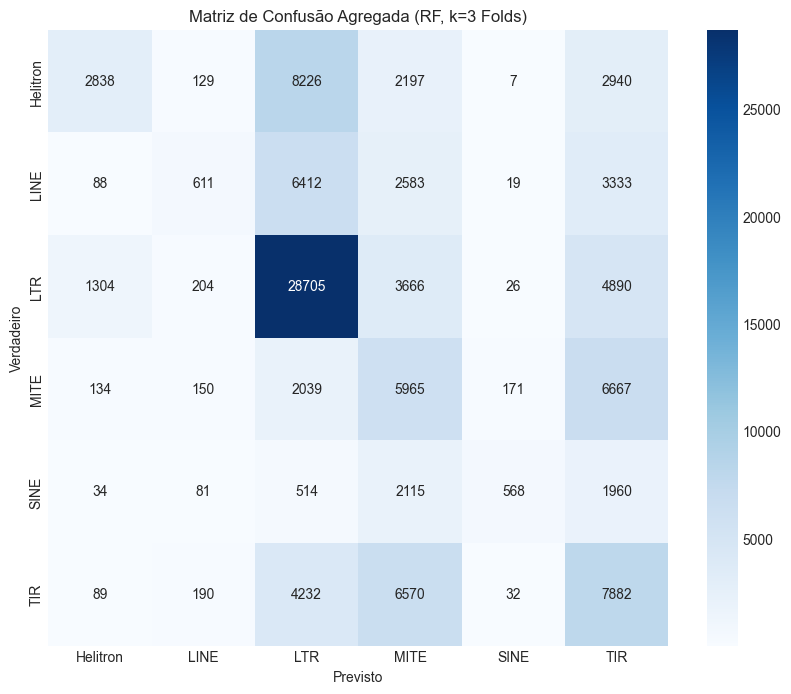

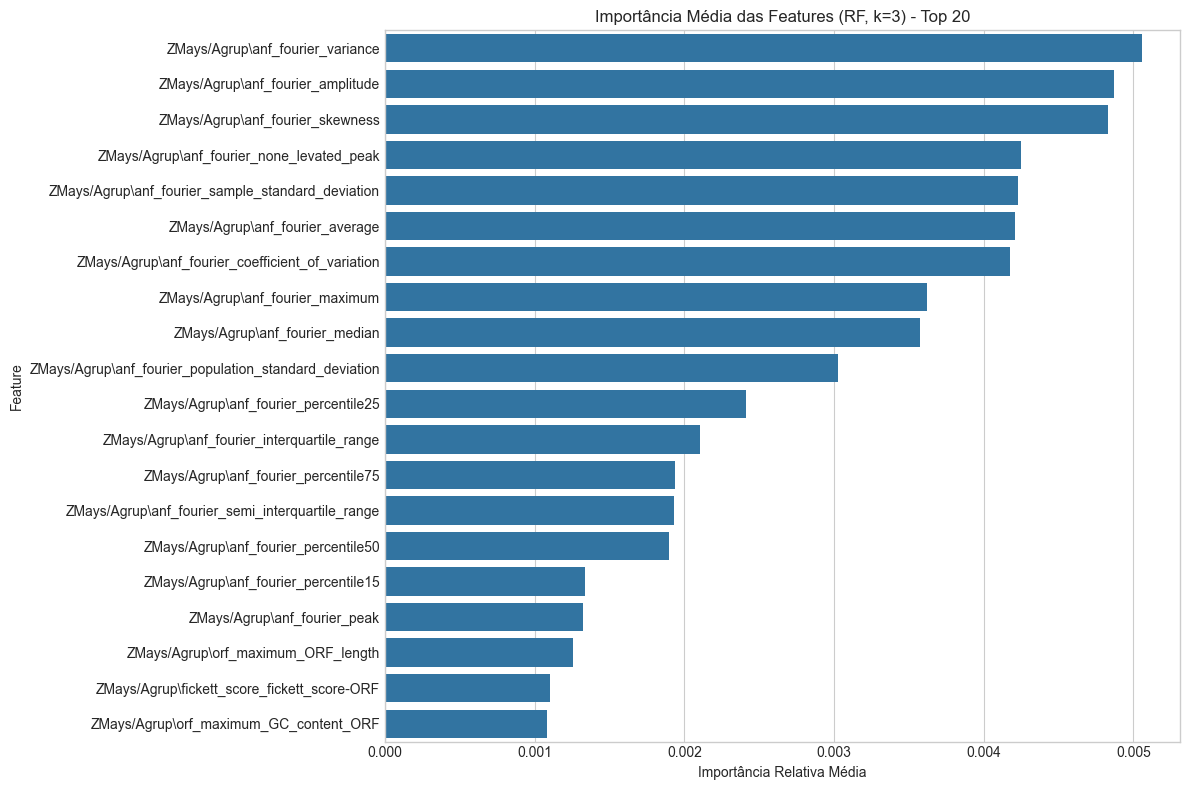

--- Iniciando Avaliação com 5 Folds para o modelo: RF ---
--- Avaliando Fold 1/5 ---
--- Avaliando Fold 2/5 ---
--- Avaliando Fold 3/5 ---
--- Avaliando Fold 4/5 ---
--- Avaliando Fold 5/5 ---

--- Resultados Agregados para o modelo RF com k = 5 ---
Acurácia Média: 0.4354 +/- 0.0014
F1-Score (Weighted) Médio: 0.4023 +/- 0.0019


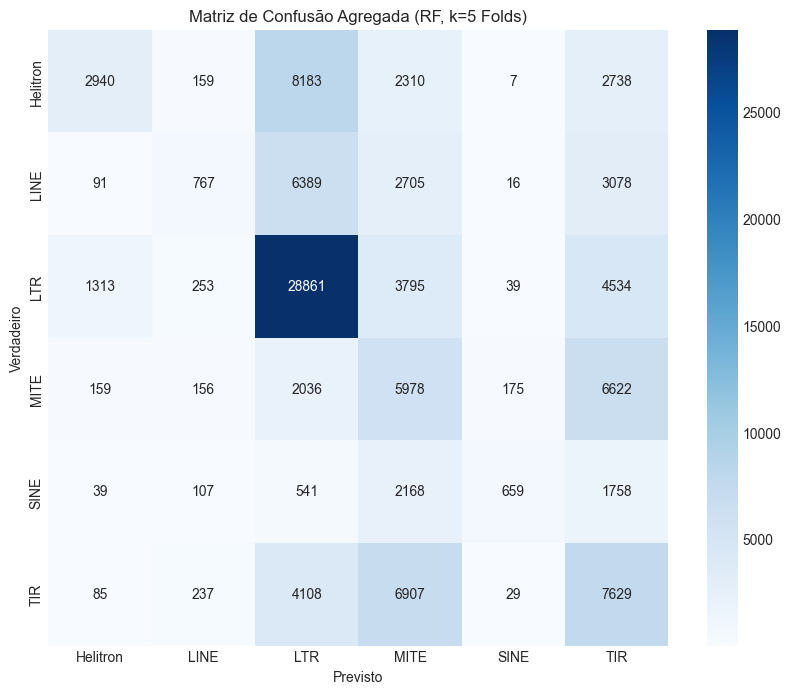

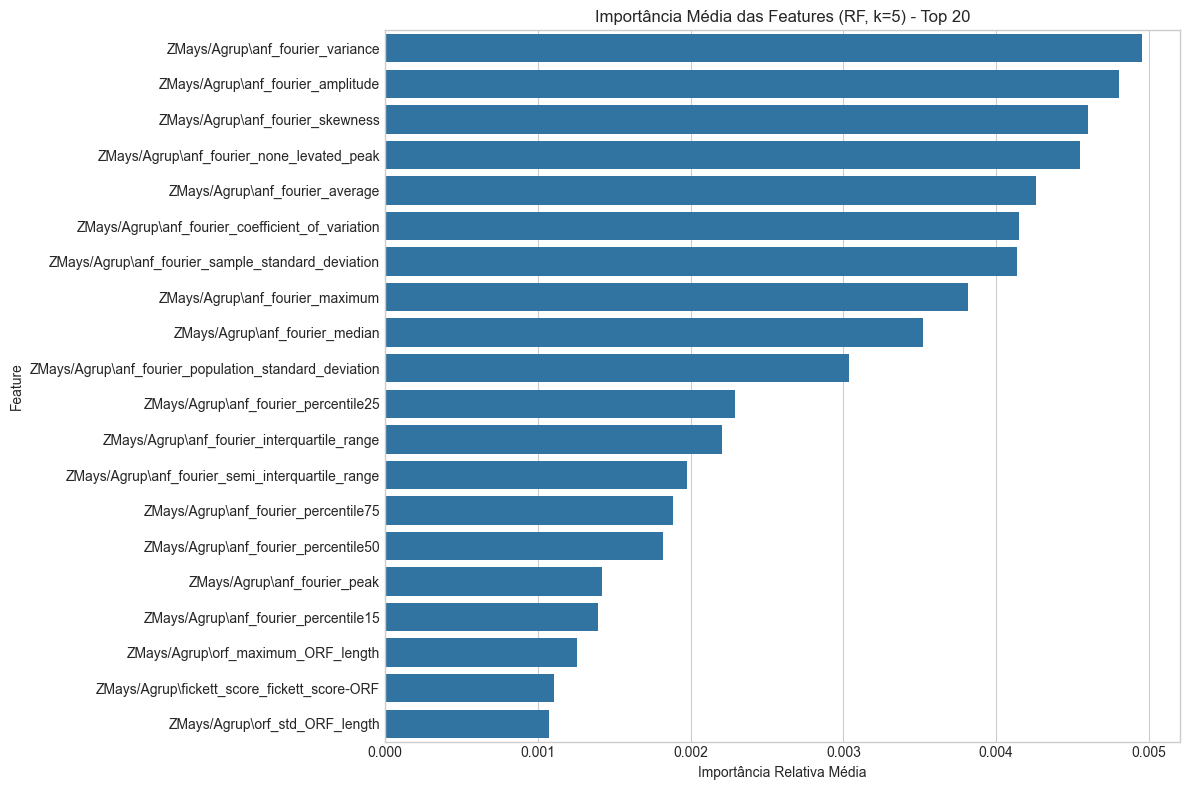

--- Iniciando Avaliação com 7 Folds para o modelo: RF ---
--- Avaliando Fold 1/7 ---
--- Avaliando Fold 2/7 ---
--- Avaliando Fold 3/7 ---
--- Avaliando Fold 4/7 ---
--- Avaliando Fold 5/7 ---
--- Avaliando Fold 6/7 ---
--- Avaliando Fold 7/7 ---

--- Resultados Agregados para o modelo RF com k = 7 ---
Acurácia Média: 0.4363 +/- 0.0026
F1-Score (Weighted) Médio: 0.4020 +/- 0.0023


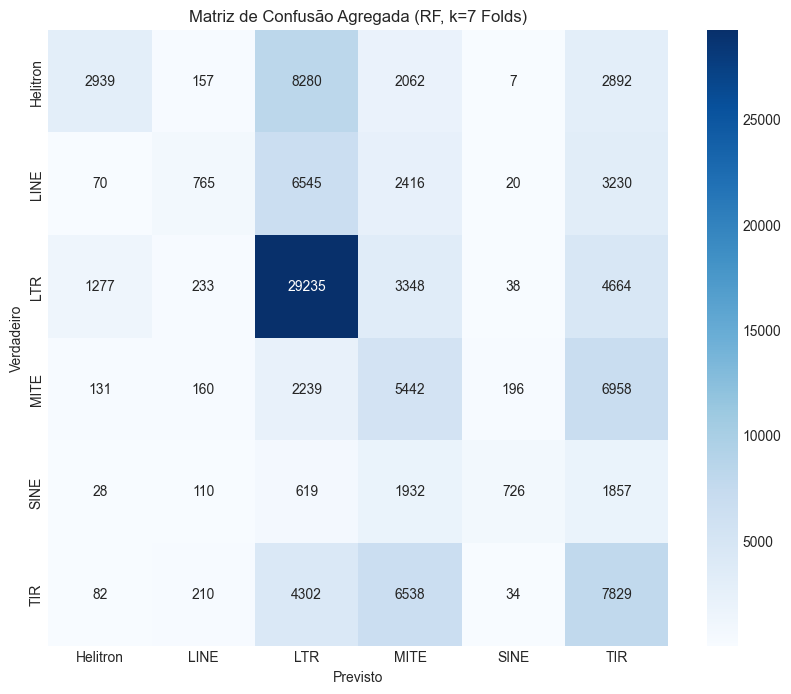

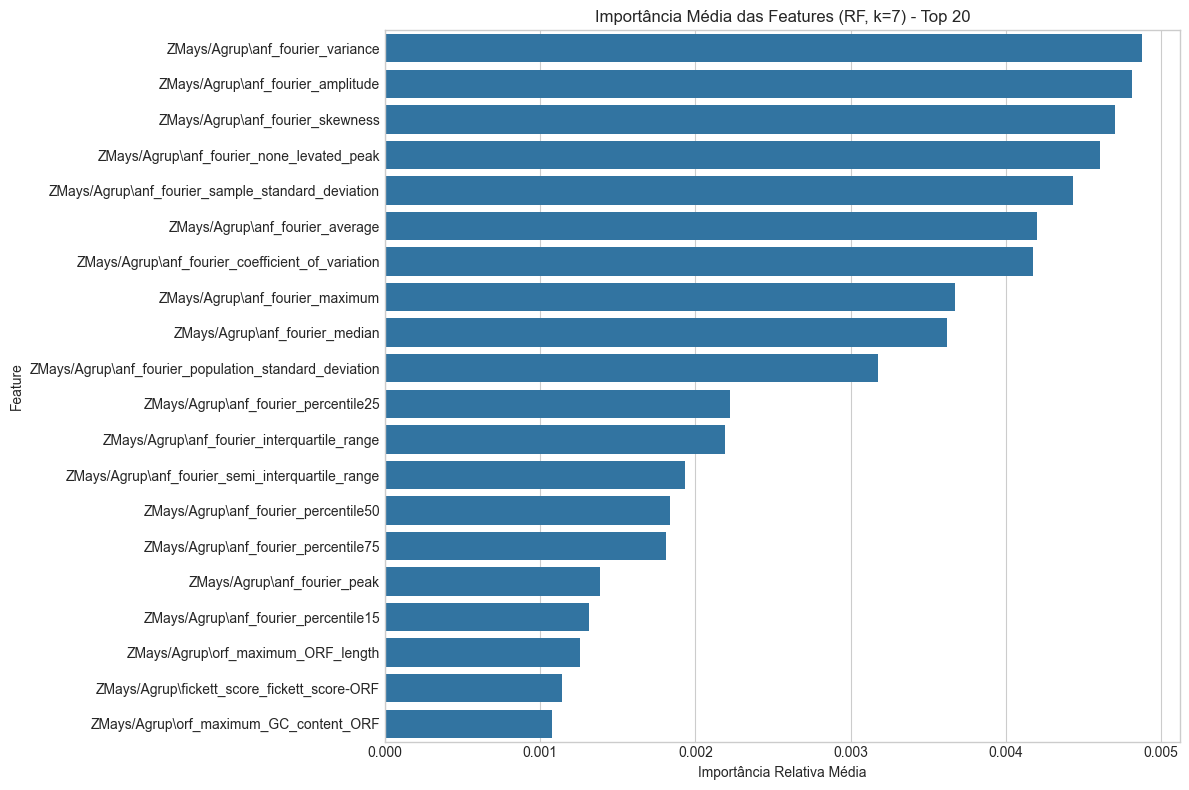

--- Iniciando Avaliação com 10 Folds para o modelo: RF ---
--- Avaliando Fold 1/10 ---
--- Avaliando Fold 2/10 ---
--- Avaliando Fold 3/10 ---
--- Avaliando Fold 4/10 ---
--- Avaliando Fold 5/10 ---
--- Avaliando Fold 6/10 ---
--- Avaliando Fold 7/10 ---
--- Avaliando Fold 8/10 ---
--- Avaliando Fold 9/10 ---
--- Avaliando Fold 10/10 ---

--- Resultados Agregados para o modelo RF com k = 10 ---
Acurácia Média: 0.4368 +/- 0.0025
F1-Score (Weighted) Médio: 0.4011 +/- 0.0031


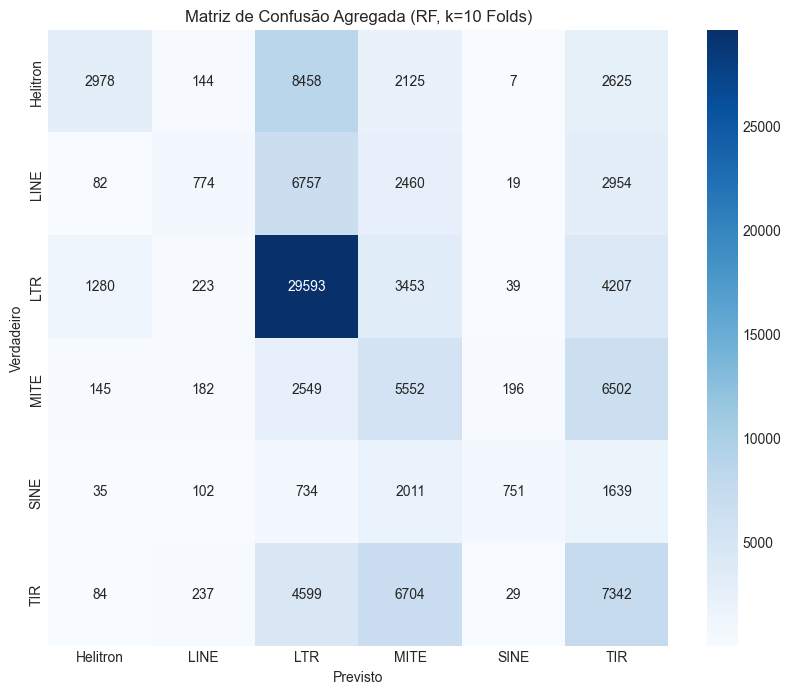

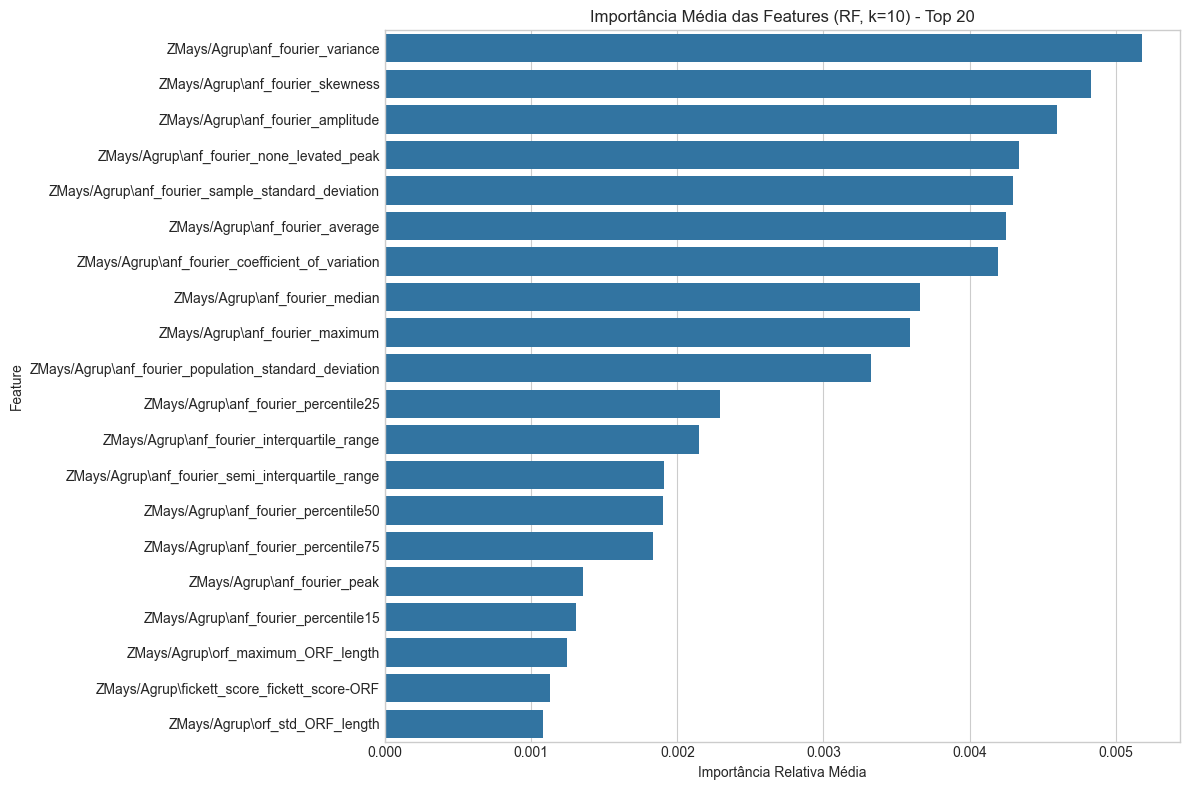

In [18]:
if 'X' in locals() and 'y' in locals():

    print(f"\n{'#'*25} INICIANDO FASE DE AVALIAÇÃO E PLOTAGEM {'#'*25}\n")
    for modelo_atual in MODELOS_PARA_TESTAR:
        for k_valor in LISTA_K_FOLDS:
            avaliar_e_plotar_modelos_kfold(
                X, y, class_names, k=k_valor, modelo_tipo=modelo_atual
            )
else:
    print("Os dados X e y não foram preparados. Verifique as células anteriores.")